In [1]:
# Import Operational Packages
import pandas as pd
import numpy as np
import os

# # Import visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Import Preprocessing, Model Construction, and Evaluation Packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve, 
    auc as sk_auc,
    classification_report
)
import xgboost as xgb
import optuna
import scipy.stats as stats
from scipy.stats import (chi2_contingency, ttest_ind, shapiro, mannwhitneyu)
from collections import Counter
import re
import shap

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

# Import Data

In [9]:
file_path = "./data/WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)

In [10]:
# Inspect the First 10 rows
df.head(10)

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   
5   32        No  Travel_Frequently       1005  Research & Development   
6   59        No      Travel_Rarely       1324  Research & Development   
7   30        No      Travel_Rarely       1358  Research & Development   
8   38        No  Travel_Frequently        216  Research & Development   
9   36        No      Travel_Rarely       1299  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   
5                 2          2  Life Sciences              1               8   
6                 3          3        Medical              1              10   
7                24          1  Life Sciences              1              11   
8                23          3  Life Sciences              1              12   
9                27          3        Medical              1              13   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   
5  ...                         3            80                 0   
6  ...                         1            80                 3   
7  ...                         2            80                 1   
8  ...                         2            80                 0   
9  ...                         2            80                 2   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   
5                  8                      2               2               7   
6                 12                      3               2               1   
7                  1                      2               3               1   
8                 10                      2               3               9   
9                 17                      3               2               7   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  
5                  7                        3                     6  
6                  0                        0                     0  
7                  0                        0                     0  
8                  7                        1             

In [11]:
# Inspect the dataframe
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [12]:
# Check for NULL values
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [13]:
# Going to drop specific columns as they may be related to
# a protected class and we want to avoid implicit bias associated
# with those
protected_class_list = [
    "Age",
    "Gender",
    "MaritalStatus",
    "Over18",
    "RelationshipSatisfaction", # Kinda a bubble case...
    "TotalWorkingYears", # Could inadverently be a proxy for a protected class
]
df.drop(columns=[col for col in protected_class_list if col in df.columns], inplace=True)

In [14]:
df.head(10)

Attrition     BusinessTravel  DailyRate              Department  \
0       Yes      Travel_Rarely       1102                   Sales   
1        No  Travel_Frequently        279  Research & Development   
2       Yes      Travel_Rarely       1373  Research & Development   
3        No  Travel_Frequently       1392  Research & Development   
4        No      Travel_Rarely        591  Research & Development   
5        No  Travel_Frequently       1005  Research & Development   
6        No      Travel_Rarely       1324  Research & Development   
7        No      Travel_Rarely       1358  Research & Development   
8        No  Travel_Frequently        216  Research & Development   
9        No      Travel_Rarely       1299  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   
5                 2          2  Life Sciences              1               8   
6                 3          3        Medical              1              10   
7                24          1  Life Sciences              1              11   
8                23          3  Life Sciences              1              12   
9                27          3        Medical              1              13   

   EnvironmentSatisfaction  ...  PercentSalaryHike  PerformanceRating  \
0                        2  ...                 11                  3   
1                        3  ...                 23                  4   
2                        4  ...                 15                  3   
3                        4  ...                 11                  3   
4                        1  ...                 12                  3   
5                        4  ...                 13                  3   
6                        3  ...                 20                  4   
7                        4  ...                 22                  4   
8                        4  ...                 21                  4   
9                        3  ...                 13                  3   

   StandardHours StockOptionLevel  TrainingTimesLastYear  WorkLifeBalance  \
0             80                0                      0                1   
1             80                1                      3                3   
2             80                0                      3                3   
3             80                0                      3                3   
4             80                1                      3                3   
5             80                0                      2                2   
6             80                3                      3                2   
7             80                1                      2                3   
8             80                0                      2                3   
9             80                2                      3                2   

   YearsAtCompany  YearsInCurrentRole YearsSinceLastPromotion  \
0               6                   4                       0   
1              10                   7                       1   
2               0                   0                       0   
3               8                   7                       3   
4               2                   2                       2   
5               7                   7                       3   
6               1                   0                       0   
7               1                   0                       0   
8               9                   7                       1   
9               7                   7                      

In [15]:
# Additional Fields to Drop since they don't really inform
fields_to_drop = [
    "EducationField",
    "EmployeeNumber",
    "EmployeeCount"  # Could be used as an aggregation field
]

# Only drop columns that exist in the DataFrame
df.drop(columns=[col for col in fields_to_drop if col in df.columns], inplace=True)

# Data Cleaning

## Functions

In [27]:
def generate_barplot(field):
    attrition_series = df["Attrition"].map({"Yes": 1, "No": 0})
    mean_attrition_rate = attrition_series.mean()
    
    if isinstance(field, str):
        target_category = pd.Series(df[field], name=field)
    elif isinstance(field, pd.Series):
        target_category = field
    else:
        raise ValueError("The 'field' argument must be either a string (column name in df) or a Series.")
    
    pattern = r'(?<!^)([A-Z])'
    field_name = re.sub(r'(?<!^)([A-Z])', r' \1', target_category.name)

    temp_df = target_category.to_frame().join(attrition_series)
    
    temp_agg_df = temp_df.groupby(target_category, observed=False).agg(
        exited_employees = ("Attrition", "sum"),
        num_employees = ("Attrition", "count")
    )
    temp_agg_df["conversion_rate"] = temp_agg_df["exited_employees"] / temp_agg_df["num_employees"]
    
    order = temp_agg_df.sort_values(by="conversion_rate", ascending=False).index

    fig, ax = plt.subplots()

    ax.set_title(f"Comparison of Attrition Rate by {field_name}", fontsize=20)

    sns.barplot(
        data=temp_agg_df, 
        x=temp_agg_df.index, 
        y='conversion_rate', 
        errorbar=None,
        order=order
    )
    ax.axhline(mean_attrition_rate, color='k', ls="--", label='Mean Attrition Rate')

    ax.set_xlabel(field_name, fontsize=16)
    ax.set_ylabel("Attrition Rate", fontsize=16)

    ax.legend()
    plt.tight_layout()
    plt.savefig(f"./Visualizations/{field}_bar_chart.png")
    plt.show()
    plt.close()


In [17]:
    
def run_chi2_test(field):
    # Check if field is a column name (string) in merged_df or a Series
    if isinstance(field, str):
        target_category = df[field]
    elif isinstance(field, pd.Series):
        target_category = field
    else:
        raise ValueError("The 'field' argument must be either a string (column name in merged_df) or a Series.")
    
    # Create the contingency table
    attrition_series = df["Attrition"].map({"Yes": 1, "No": 0})
    contingency_table = pd.crosstab(target_category, attrition_series)
    
    # Check for empty rows/columns in contingency_table to avoid chi2_contingency errors
    if contingency_table.size == 0:
        raise ValueError("Contingency table is empty or contains no data.")
    
    # Perform chi-squared test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Calculate residuals
    observed = contingency_table.values
    residuals = (observed - expected) / (expected ** 0.5)
    residuals_df = pd.DataFrame(residuals, index=contingency_table.index, columns=contingency_table.columns)
    
    # Identify low-contributing categories
    low_contrib_categories = residuals_df[(residuals_df.abs() < 1).all(axis=1)]
    
    # Output results
    print(f"Chi-square statistic: {chi2}, p-value: {p}")
    print(f"{len(low_contrib_categories)} of {len(residuals_df)} to potentially group into OTHER")
    
    return low_contrib_categories

In [18]:
def determine_baseline_factor(category):
    # Check if "OTHER" is in the category column
    if "OTHER" in categorical_df[category].values:
        baseline_factor = f"{category}_OTHER"
    else:
        # Calculate the mean attrition rate
        mean_attrition_rate = attrition_series.mean()
        
        # Join attrition data and calculate attrition rate by category
        temp_df = categorical_df[[category]].join(attrition_series)
        temp_df = temp_df.groupby(category).agg(
            attrition_count=("Attrition", "sum"),
            num_employees=("Attrition", "count")
        )
        temp_df["attrition_rate"] = temp_df["attrition_count"] / temp_df["num_employees"]
        
        # Find the category with the attrition rate closest to the mean
        closest_to_mean = (temp_df["attrition_rate"] - mean_attrition_rate).abs().idxmin()
        baseline_factor = f"{category}_{closest_to_mean}"

    return baseline_factor

In [19]:
def impute_other_in_field(series, labels):
    # Check if field is a column name (string) in merged_df or a Series
    if isinstance(series, str):
        target_category = df[series]
    elif isinstance(series, pd.Series):
        target_category = series
    else:
        raise ValueError("The 'field' argument must be either a string (column name in merged_df) or a Series.")
    
    series = series.apply(lambda x: "OTHER" if x in labels else x)
    
    return series

In [20]:
def calculate_q_cuts(field):
    data_range = df[field].max() - df[field].min()
    iqr = df[field].quantile(0.75) - df[field].quantile(0.25)
    bin_width = 2 * iqr * (len(df) ** (-1/3))
    q = int(data_range / bin_width)

    return q

In [21]:
def create_interaction_effects(X, col1, col2, y, p_value_threshold=0.05):
    # Remove duplicate columns in X, if any
    X = X.loc[:, ~X.columns.duplicated()]
    
    # Create a working copy of X to avoid modifying the original DataFrame
    working_df = X.copy()

    # Select features that contain col1 and col2 in their names
    col1_features = [col for col in X.columns if col1 in col]
    col2_features = [col for col in X.columns if col2 in col]

    # Create pairs of features
    pair_values = [(x, y) for x in col1_features for y in col2_features]

    # Initialize an empty DataFrame to hold interaction terms
    interaction_df = pd.DataFrame(index=X.index)

    # Generate interaction terms for each pair and add them to the DataFrame
    for i, j in pair_values:
        interaction_name = f"{i}_x_{j}"
        
        # Only add interaction if it doesn't already exist
        if interaction_name not in interaction_df.columns:
            interaction_df[interaction_name] = X[i] * X[j]

    chi2_results = []

    # Perform chi-squared test for each interaction feature
    for column in interaction_df.columns:
        contingency_table = pd.crosstab(interaction_df[column], y)

        try:
            chi2_stat, p, _, _ = chi2_contingency(contingency_table)
        except ValueError as e:
            # Handle errors that may occur due to incompatible contingency table
            print(f"Skipping feature {column} due to error: {e}")
            continue

        # Store the results
        chi2_results.append({'Feature': column, 'Chi2 Stat': chi2_stat, 'p-value': p})

    # Convert chi-squared test results into a DataFrame and filter based on p-value threshold
    chi2_results_df = pd.DataFrame(chi2_results)
    chi2_results_df = chi2_results_df.sort_values(by='p-value').reset_index(drop=True)

    # Select only the significant interaction terms
    significant_factors = list(
        chi2_results_df[chi2_results_df['p-value'] < p_value_threshold]["Feature"]
    )
    
    # Filter the interaction DataFrame to keep only significant features
    filtered_interaction_df = interaction_df[significant_factors]

    # Add the filtered interaction terms to the working DataFrame
    working_df = working_df.join(filtered_interaction_df)

    # Print the shape of the updated DataFrame
    print("Updated DataFrame shape:", working_df.shape)
    
    # Sort the index for consistency
    working_df = working_df.sort_index(ascending=True)

    return working_df


## Attrition: Our Dependent Variable

In [22]:
df["Attrition"].value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

In [23]:
# Convert Attrition, our target, to binomial
attrition_map = {"Yes": 1, "No": 0}
attrition_series = df["Attrition"].map(attrition_map)
attrition_series.value_counts(normalize=True)

Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64

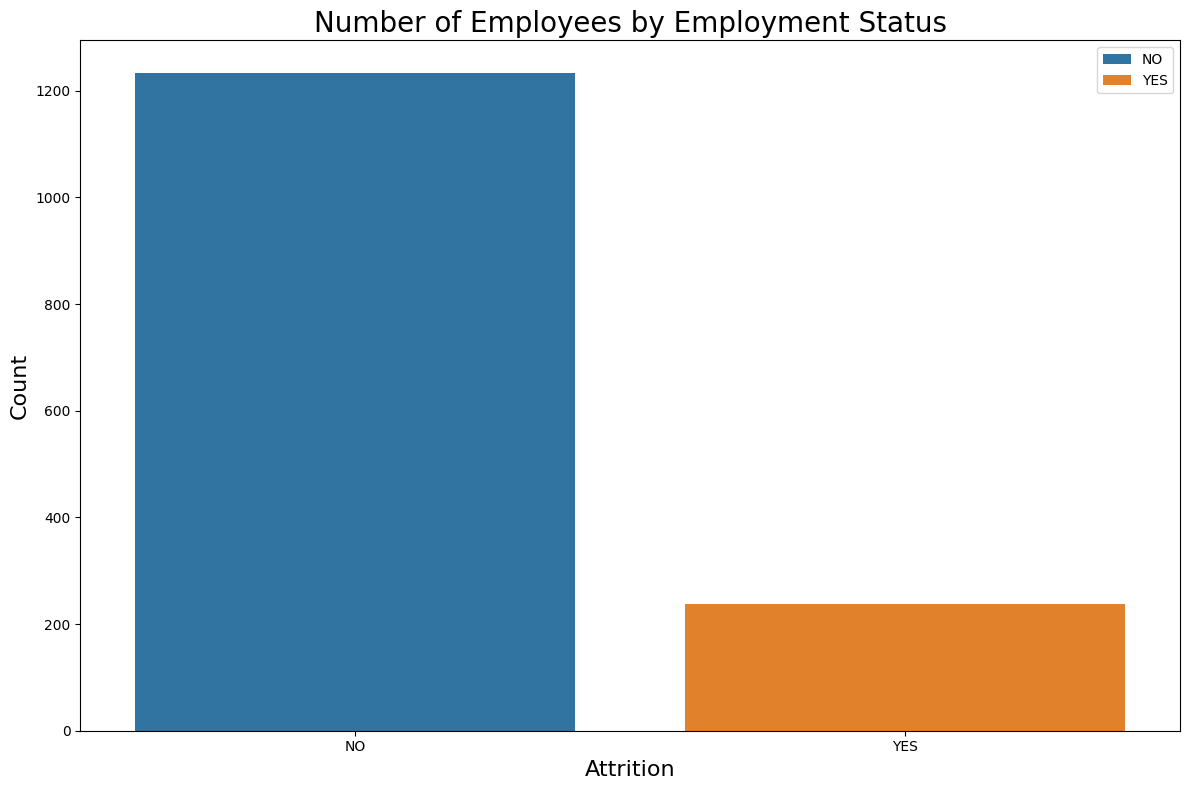

In [24]:
attrition_labels = ["NO", "YES"]
fig, ax = plt.subplots()
ax.set_title("Number of Employees by Employment Status", fontsize=20)

sns.countplot(x=attrition_series, ax=ax, hue=attrition_series)
ax.set_xlabel("Attrition", fontsize=16)
ax.set_xticks([0, 1])
ax.set_xticklabels(labels=attrition_labels)
ax.set_ylabel("Count", fontsize=16)

ax.legend(labels=attrition_labels)

plt.tight_layout()
plt.savefig("./Visualizations/bar_graph_attrition.png")
plt.show()

## Business Travel

In [25]:
df["BusinessTravel"].value_counts(normalize=True)

BusinessTravel
Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: proportion, dtype: float64

In [26]:
# Standardize the case and remove special charaters
business_travel_series = df["BusinessTravel"].str.upper().str.replace("-", "_")

OSError: [Errno 63] File name too long: '/Users/christopher.gonzales/portfolio/Visualizations/0           TRAVEL_RARELY\n1       TRAVEL_FREQUENTLY\n2           TRAVEL_RARELY\n3       TRAVEL_FREQUENTLY\n4           TRAVEL_RARELY\n              ...        \n1465    TRAVEL_FREQUENTLY\n1466        TRAVEL_RARELY\n1467        TRAVEL_RARELY\n1468    TRAVEL_FREQUENTLY\n1469        TRAVEL_RARELY\nName: BusinessTravel, Length: 1470, dtype: object_bar_chart.png'

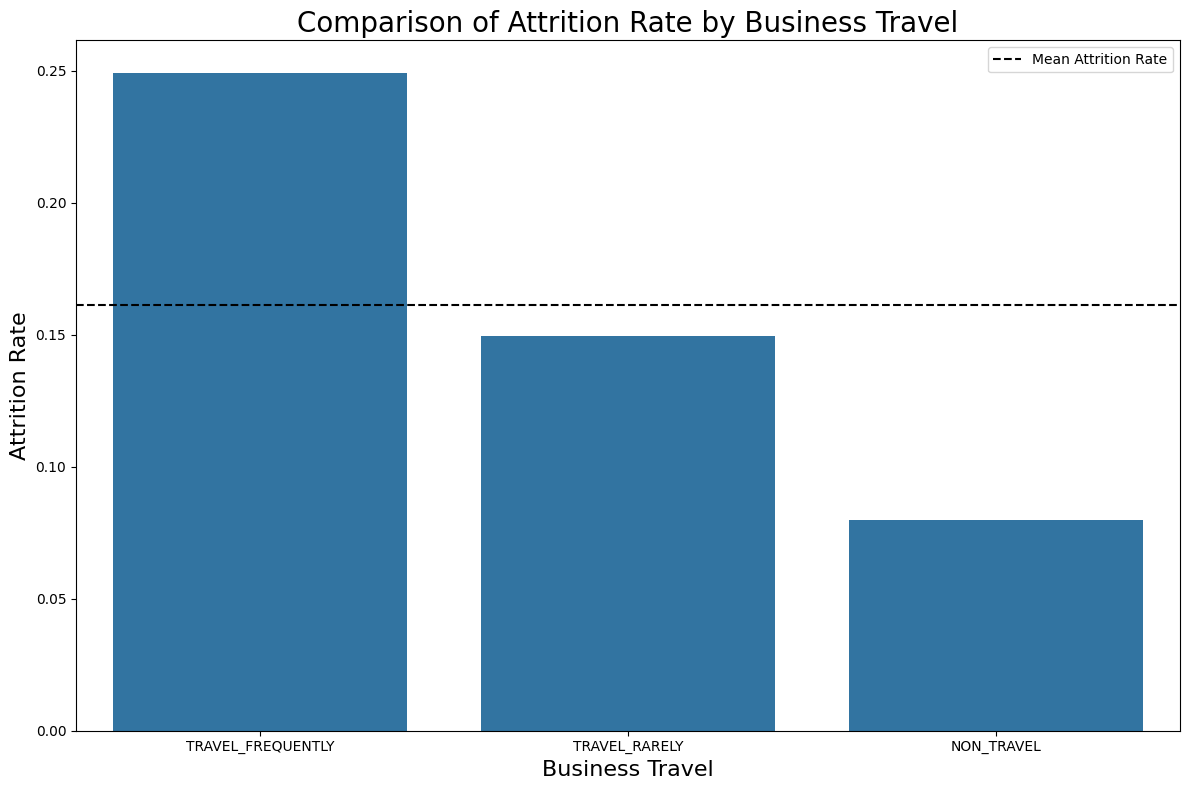

In [28]:
generate_barplot(business_travel_series)

In [22]:
run_chi2_test(business_travel_series)

Chi-square statistic: 24.182413685655174, p-value: 5.608614476449931e-06
1 of 3 to potentially group into OTHER


Attrition              0         1
BusinessTravel                    
TRAVEL_RARELY   0.411023 -0.937506

## Daily Rate
Numerical Value - Salary Level

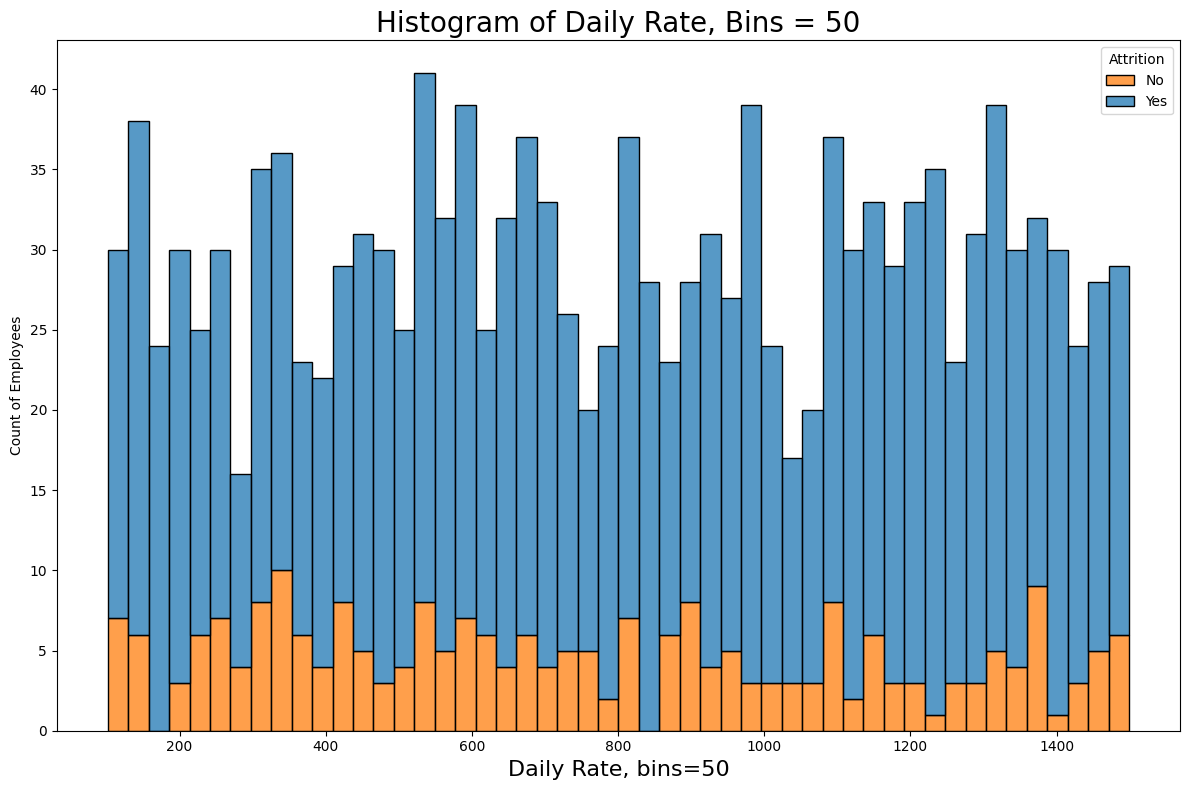

In [23]:
fig, ax = plt.subplots()
ax.set_title("Histogram of Daily Rate, Bins = 50", fontsize=20)

sns.histplot(data=df, x="DailyRate", bins=50, hue=attrition_series, multiple="stack")

ax.set_xlabel("Daily Rate, bins=50", fontsize=16)
ax.set_ylabel("Count of Employees", )

ax.legend(title="Attrition", labels=["No", 'Yes'])

plt.tight_layout()
plt.show()
plt.close()

In [24]:
q = calculate_q_cuts("DailyRate")

daily_rate_series, daily_rate_edges = pd.qcut(
    df["DailyRate"], 
    q=q, 
    labels=np.arange(q), 
    retbins=True
)

daily_rate_bins = {}
for x in np.arange(0, len(daily_rate_edges) - 1):
    left_bound = float(daily_rate_edges[x])
    right_bound = float(daily_rate_edges[x + 1])

    daily_rate_bins[f"daily_rate_{x}"] = (left_bound, right_bound)

daily_rate_bins

{'daily_rate_0': (102.0, 228.0),
 'daily_rate_1': (228.0, 360.18181818181824),
 'daily_rate_2': (360.18181818181824, 495.6363636363636),
 'daily_rate_3': (495.6363636363636, 604.0),
 'daily_rate_4': (604.0, 720.7272727272727),
 'daily_rate_5': (720.7272727272727, 863.090909090909),
 'daily_rate_6': (863.090909090909, 990.0),
 'daily_rate_7': (990.0, 1128.727272727273),
 'daily_rate_8': (1128.727272727273, 1246.0),
 'daily_rate_9': (1246.0, 1369.4545454545455),
 'daily_rate_10': (1369.4545454545455, 1499.0)}

/var/folders/w3/znbxr0vn1f55dpxxjj00nqq80000gq/T/ipykernel_86323/765131643.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_agg_df = temp_df.groupby(target_category).agg(


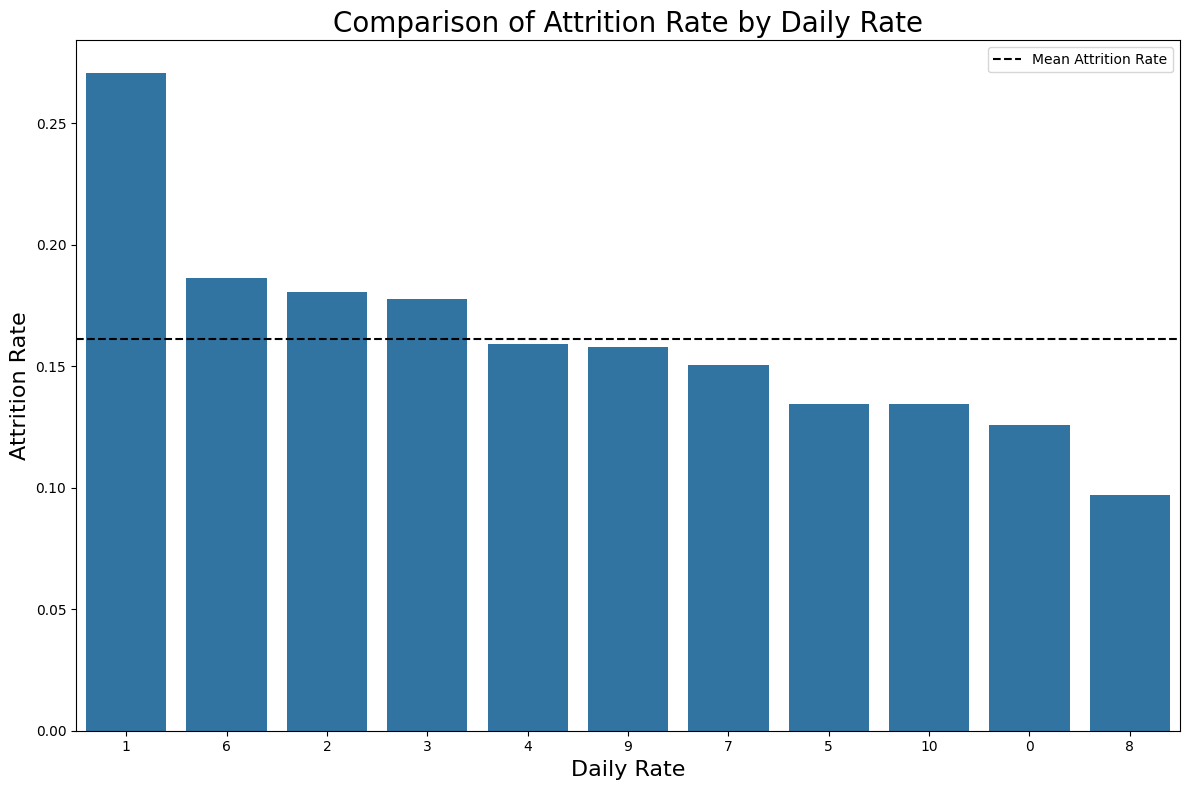

In [25]:
generate_barplot(daily_rate_series)

In [26]:
daily_rate_chi2_df = run_chi2_test(daily_rate_series)
daily_rate_OTHER = list(daily_rate_chi2_df.index)

Chi-square statistic: 19.949564975249512, p-value: 0.029733343694072906
8 of 11 to potentially group into OTHER


In [27]:
daily_rate_series = impute_other_in_field(daily_rate_series, daily_rate_OTHER)


In [28]:
run_chi2_test(daily_rate_series)

Chi-square statistic: 17.121092375926754, p-value: 0.0006673482973796155
1 of 4 to potentially group into OTHER


Attrition         0         1
DailyRate                    
OTHER      0.039684 -0.090516

## Department

In [29]:
df["Department"].value_counts()

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64

In [30]:
department_series = df["Department"].str.upper().str.replace(" ", "_")
department_series.value_counts()

Department
RESEARCH_&_DEVELOPMENT    961
SALES                     446
HUMAN_RESOURCES            63
Name: count, dtype: int64

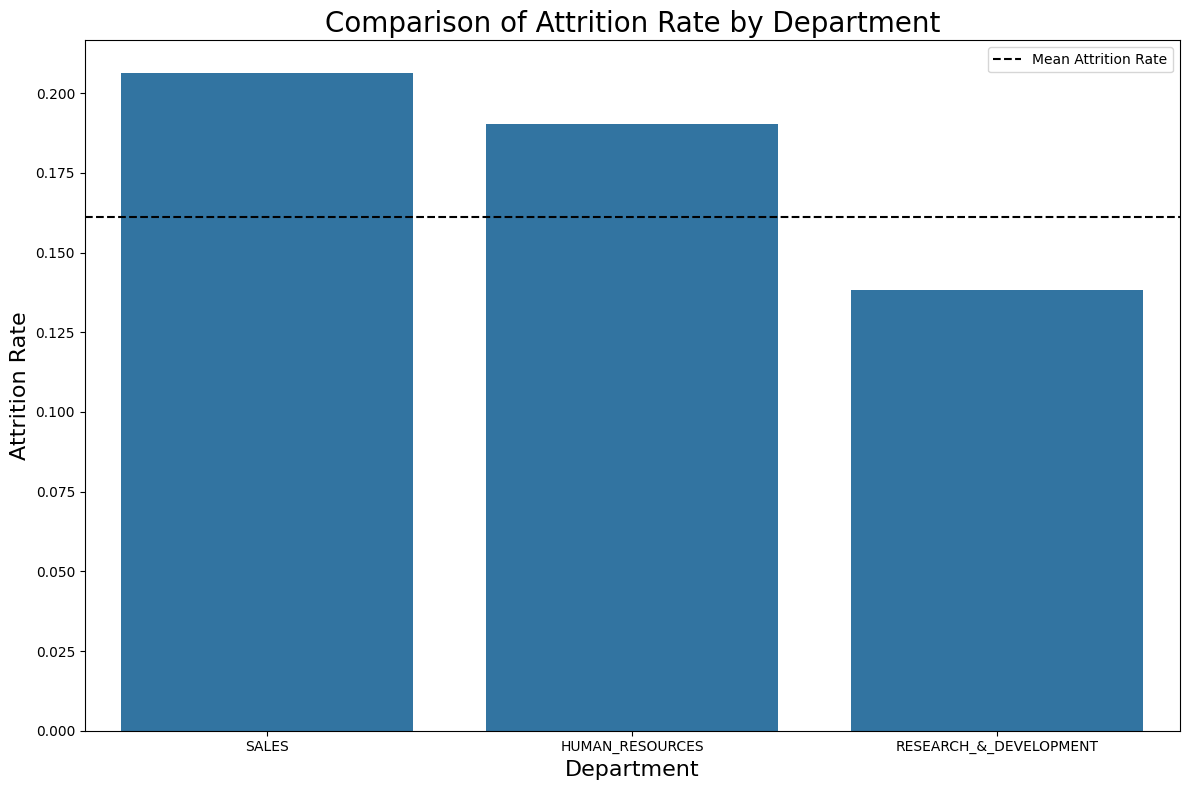

In [31]:
generate_barplot(department_series)

In [32]:
dept_chi2_df = run_chi2_test(department_series)
dept_labels = list(dept_chi2_df.index)


Chi-square statistic: 10.79600732241067, p-value: 0.004525606574479633
1 of 3 to potentially group into OTHER


In [33]:
department_series = impute_other_in_field(department_series, dept_labels)


In [34]:
run_chi2_test(department_series)

Chi-square statistic: 10.79600732241067, p-value: 0.004525606574479633
1 of 3 to potentially group into OTHER


Attrition          0         1
Department                    
OTHER      -0.253512  0.578237

## Distance From Home
Numerical Value - THE DISTANCE FROM WORK TO HOME

In [35]:
distance_series = df["DistanceFromHome"]
distance_series.describe()

count    1470.000000
mean        9.192517
std         8.106864
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: DistanceFromHome, dtype: float64

In [36]:
distance_series.corr(attrition_series)

np.float64(0.07792358295570372)

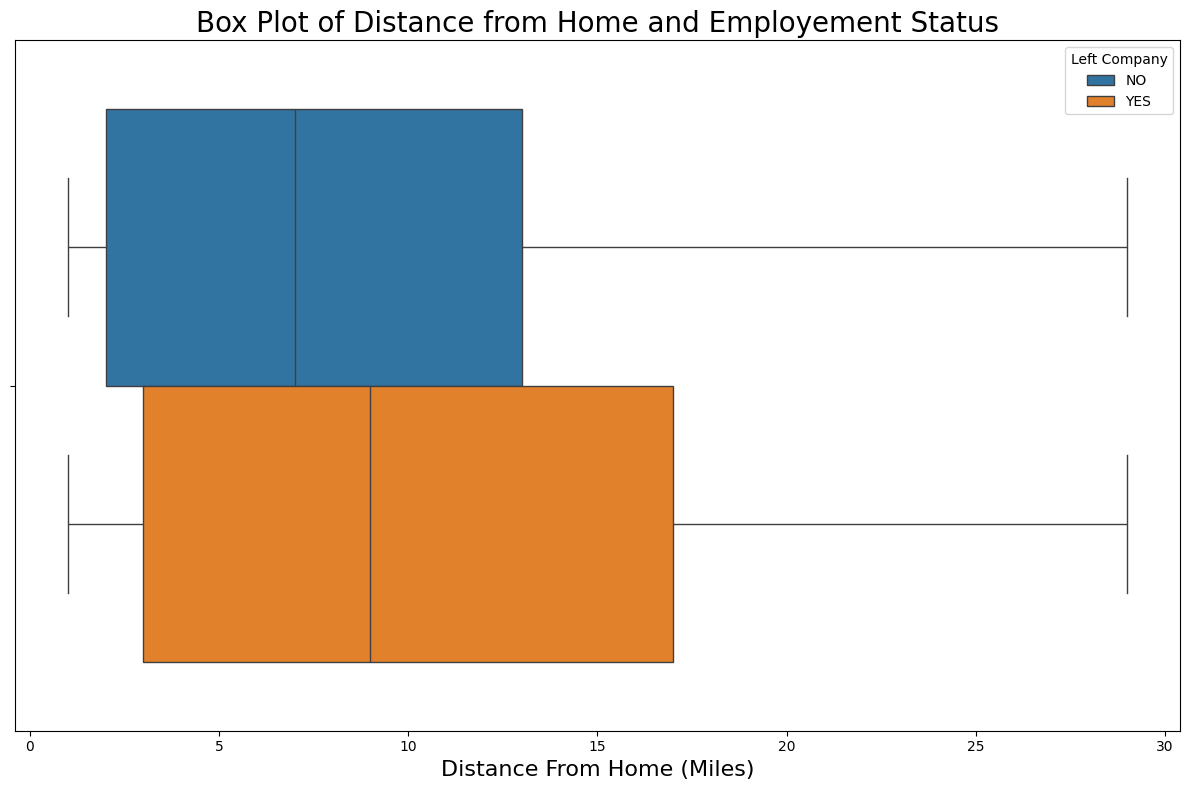

In [37]:
labels = ["NO", "YES"]

fig, ax = plt.subplots()

ax.set_title("Box Plot of Distance from Home and Employement Status", fontsize=20)

sns.boxplot(x=distance_series, hue=attrition_series)

ax.set_xlabel("Distance From Home (Miles)", fontsize=16)

ax.legend(title="Left Company", labels=labels)

plt.tight_layout()
plt.show()
plt.close()

In [38]:
log_distance_series = np.log(distance_series)
log_distance_df = log_distance_series.to_frame().join(attrition_series)

attrition_0 = log_distance_df[log_distance_df["Attrition"] == 0]
attrition_1 = log_distance_df[log_distance_df["Attrition"] == 1]

print("Shapiro test for Attrition = 0:", shapiro(attrition_0))
print("Shapiro test for Attrition = 1:", shapiro(attrition_1))

Shapiro test for Attrition = 0: ShapiroResult(statistic=np.float64(0.7401650899246233), pvalue=np.float64(2.579640037244966e-52))
Shapiro test for Attrition = 1: ShapiroResult(statistic=np.float64(0.8302724322901522), pvalue=np.float64(4.661295894399004e-22))


In [39]:
u_stat, p_val = mannwhitneyu(attrition_0, attrition_1, alternative='two-sided')

print("Mann-Whitney U test results:", u_stat, p_val)

Mann-Whitney U test results: [127995.5      0. ] [0.00238705 0.        ]


In [40]:
q = calculate_q_cuts("DistanceFromHome")
distance_series_binned, distance_bin_edges = pd.qcut(
    df["DistanceFromHome"], q=q, retbins=True, duplicates="drop"
)

num_bins = len(distance_series_binned.value_counts())
count = 0
labels_map = {}

for label in distance_series_binned.value_counts().sort_index().index:
    labels_map[label] = count
    count += 1

distance_series_binned = distance_series_binned.map(labels_map)
distance_series_binned.value_counts()

DistanceFromHome
0     419
4     164
8     125
3     124
7     115
10    112
9      92
6      86
5      85
1      84
2      64
Name: count, dtype: int64

In [41]:
distance_binned_df = distance_series_binned.to_frame().join(attrition_series)
distance_binned_df = distance_binned_df.groupby("DistanceFromHome",observed=False).agg(
    attrition_count = ("Attrition", "sum"),
    num_employees = ("Attrition", "count")
)

attrition_count = distance_binned_df["attrition_count"]
num_employees = distance_binned_df["num_employees"]

distance_binned_df["attrition_rate"] = attrition_count / num_employees
distance_binned_df

attrition_count  num_employees  attrition_rate
DistanceFromHome                                                
0                              54            419        0.128878
1                              14             84        0.166667
2                               9             64        0.140625
3                              17            124        0.137097
4                              21            164        0.128049
5                              18             85        0.211765
6                              11             86        0.127907
7                              25            115        0.217391
8                              23            125        0.184000
9                              26             92        0.282609
10                             19            112        0.169643

/var/folders/w3/znbxr0vn1f55dpxxjj00nqq80000gq/T/ipykernel_86323/765131643.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_agg_df = temp_df.groupby(target_category).agg(


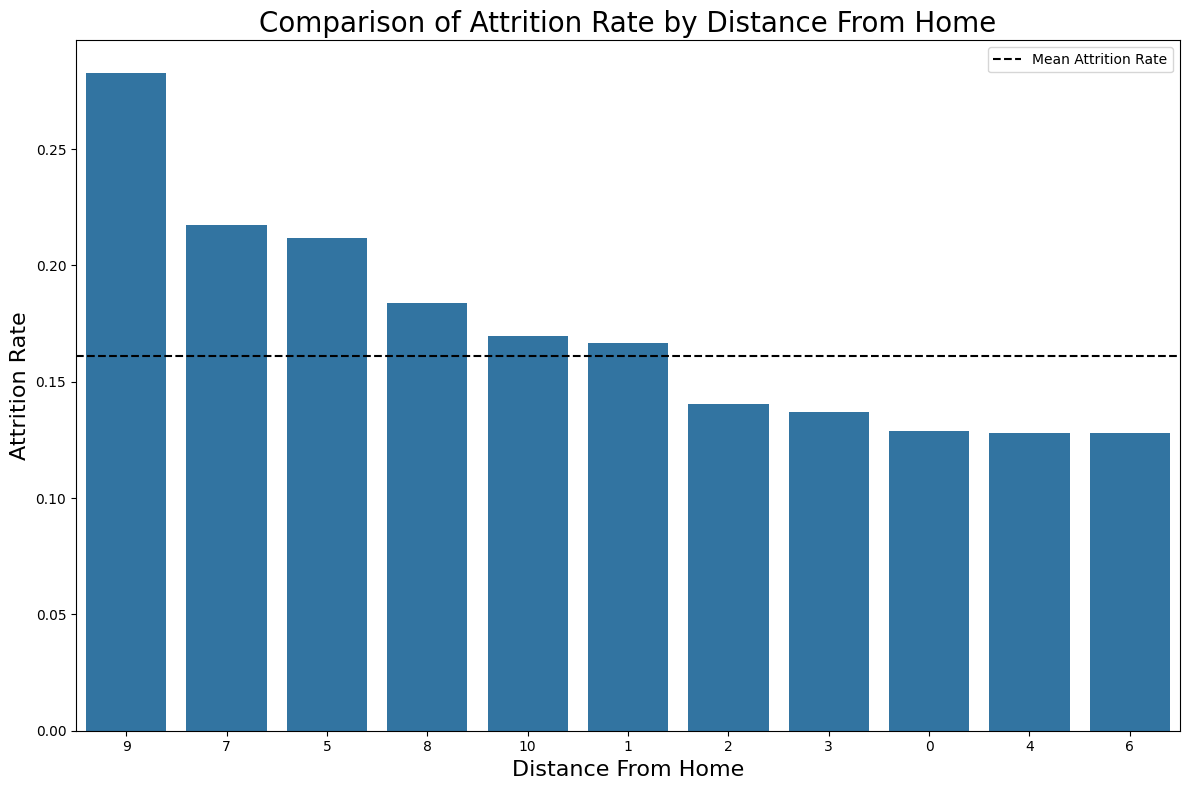

In [42]:
generate_barplot(distance_series_binned)

In [43]:
distance_chi2_df = run_chi2_test(distance_series_binned)
distance_fields = list(distance_chi2_df.index)

Chi-square statistic: 20.885834109393873, p-value: 0.02190386878522257
6 of 11 to potentially group into OTHER


In [44]:
distance_series_binned = impute_other_in_field(distance_series_binned, distance_fields)

In [45]:
run_chi2_test(distance_series_binned)

Chi-square statistic: 18.99529288591091, p-value: 0.0019260210675671355
1 of 6 to potentially group into OTHER


Attrition                0         1
DistanceFromHome                    
OTHER             0.131091 -0.299007

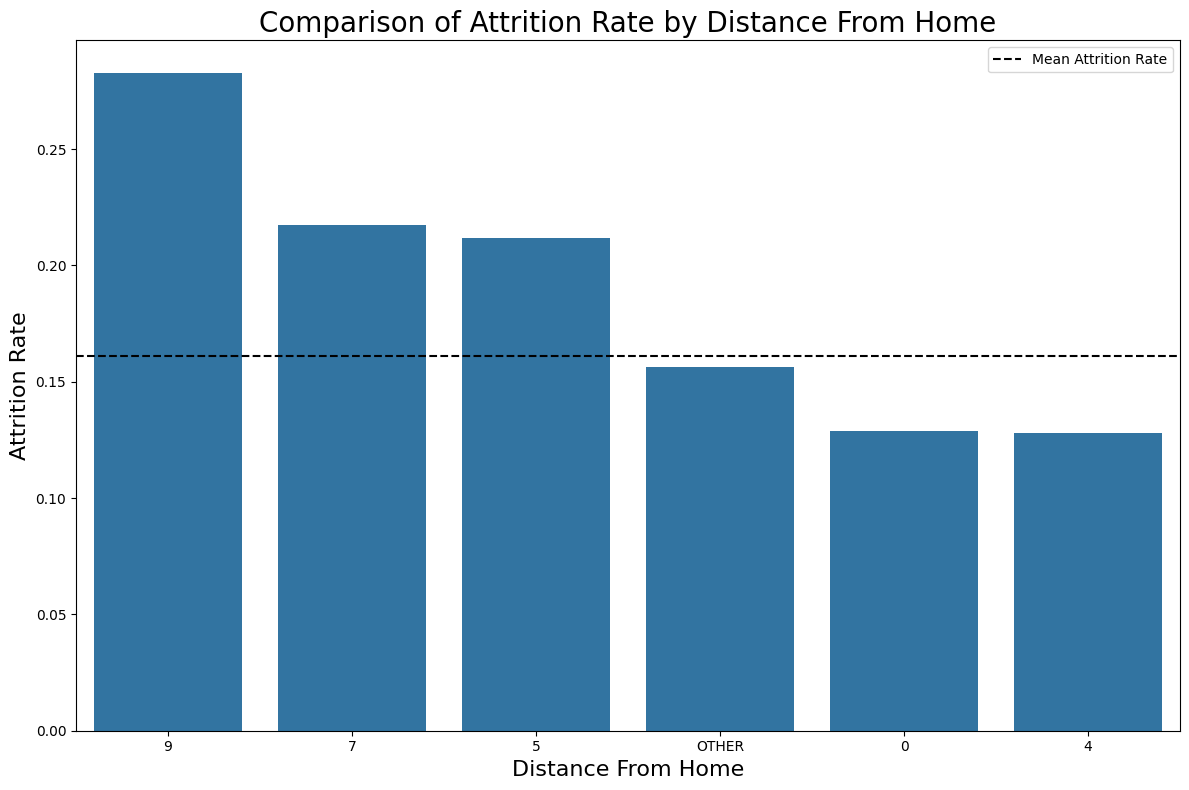

In [46]:
generate_barplot(distance_series_binned)

## Education Field
(1=HR, 2=LIFE SCIENCES, 3=MARKETING, 4=MEDICAL SCIENCES, 5=OTHERS, 6= TEHCNICAL)

In [47]:
education_mapping = {
    "1": "HR",
    "2": "LIFE_SCIENCES",
    "3": "MARKETING",
    "4": "MEDICAL_SCIENCES",
    "5": "OTHERS",
    "6": "TECHNICAL"
}

education_series = df["Education"].astype(str).map(education_mapping)
education_series.value_counts()

Education
MARKETING           572
MEDICAL_SCIENCES    398
LIFE_SCIENCES       282
HR                  170
OTHERS               48
Name: count, dtype: int64

In [48]:
run_chi2_test(education_series)

Chi-square statistic: 3.0739613982367193, p-value: 0.5455253376565949
5 of 5 to potentially group into OTHER


Attrition                0         1
Education                           
HR               -0.300794  0.686083
LIFE_SCIENCES     0.095275 -0.217314
MARKETING        -0.309516  0.705976
MEDICAL_SCIENCES  0.337547 -0.769912
OTHERS            0.431631 -0.984510

In [49]:
education_df = education_series.to_frame().join(attrition_series)
education_agg_df = education_df.groupby("Education").agg(
    attrition_count=("Attrition", 'sum'),
    num_employess=("Attrition", "count")
)

attrition_count = education_agg_df["attrition_count"]
num_employees = education_agg_df["num_employess"]

education_agg_df["attrition_rate"] = attrition_count / num_employees

education_agg_df

attrition_count  num_employess  attrition_rate
Education                                                       
HR                             31            170        0.182353
LIFE_SCIENCES                  44            282        0.156028
MARKETING                      99            572        0.173077
MEDICAL_SCIENCES               58            398        0.145729
OTHERS                          5             48        0.104167

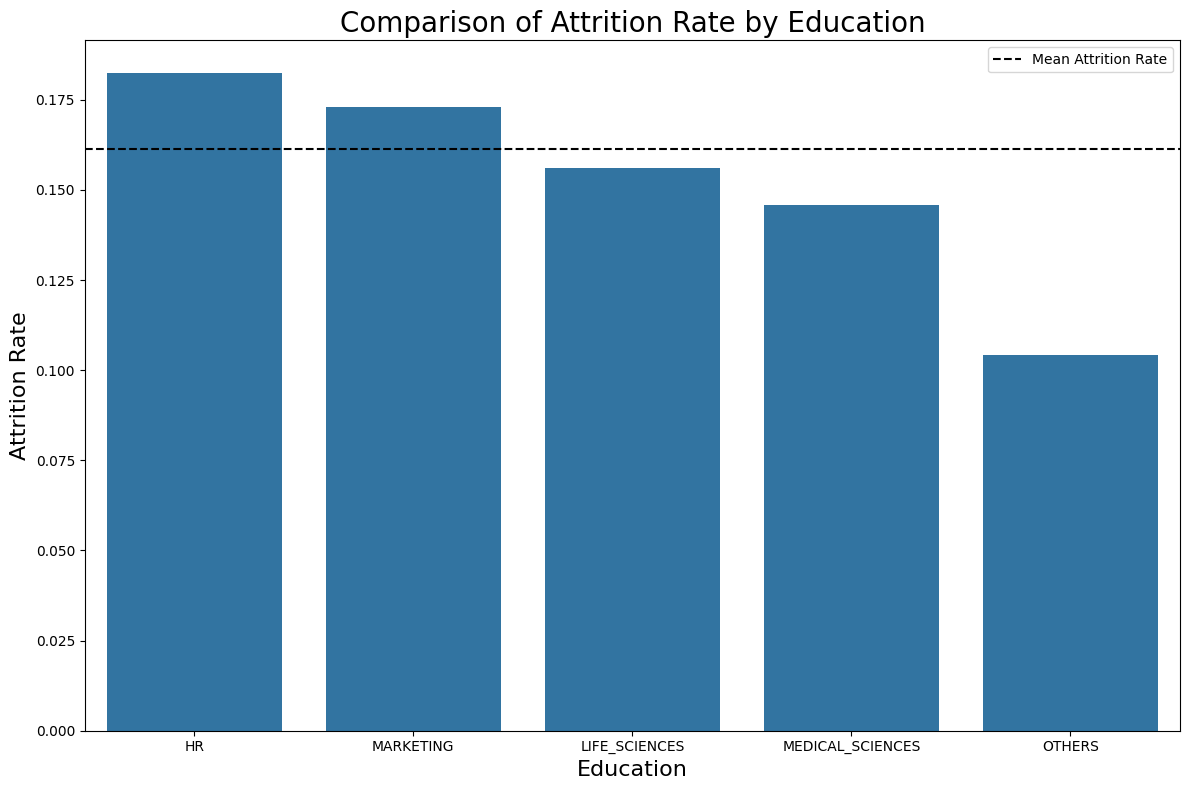

In [50]:
generate_barplot(education_series)

## Environment Satisfaction

In [51]:
env_satisfaction_series = df["EnvironmentSatisfaction"]
env_satisfaction_series.value_counts()

EnvironmentSatisfaction
3    453
4    446
2    287
1    284
Name: count, dtype: int64

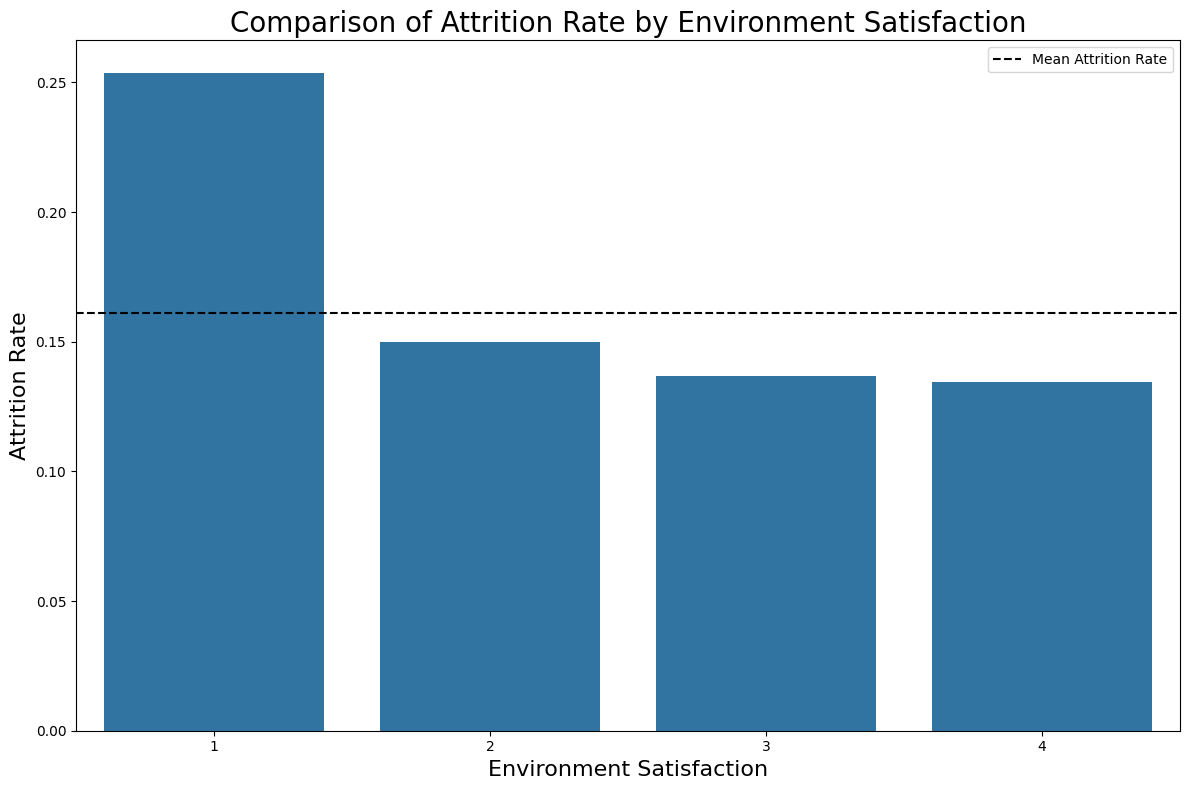

In [52]:
generate_barplot(env_satisfaction_series)

In [53]:
env_chi2_df = run_chi2_test(env_satisfaction_series)
env_labels = list(env_chi2_df.index)


Chi-square statistic: 22.503881435842295, p-value: 5.123468906289425e-05
1 of 4 to potentially group into OTHER


In [54]:
env_satisfaction_series = impute_other_in_field(env_satisfaction_series, env_labels)

## Hourly Rate

In [55]:
hourly_series = df["HourlyRate"]
hourly_series.value_counts()

HourlyRate
66    29
98    28
42    28
48    28
84    28
      ..
31    15
53    14
68    14
38    13
34    12
Name: count, Length: 71, dtype: int64

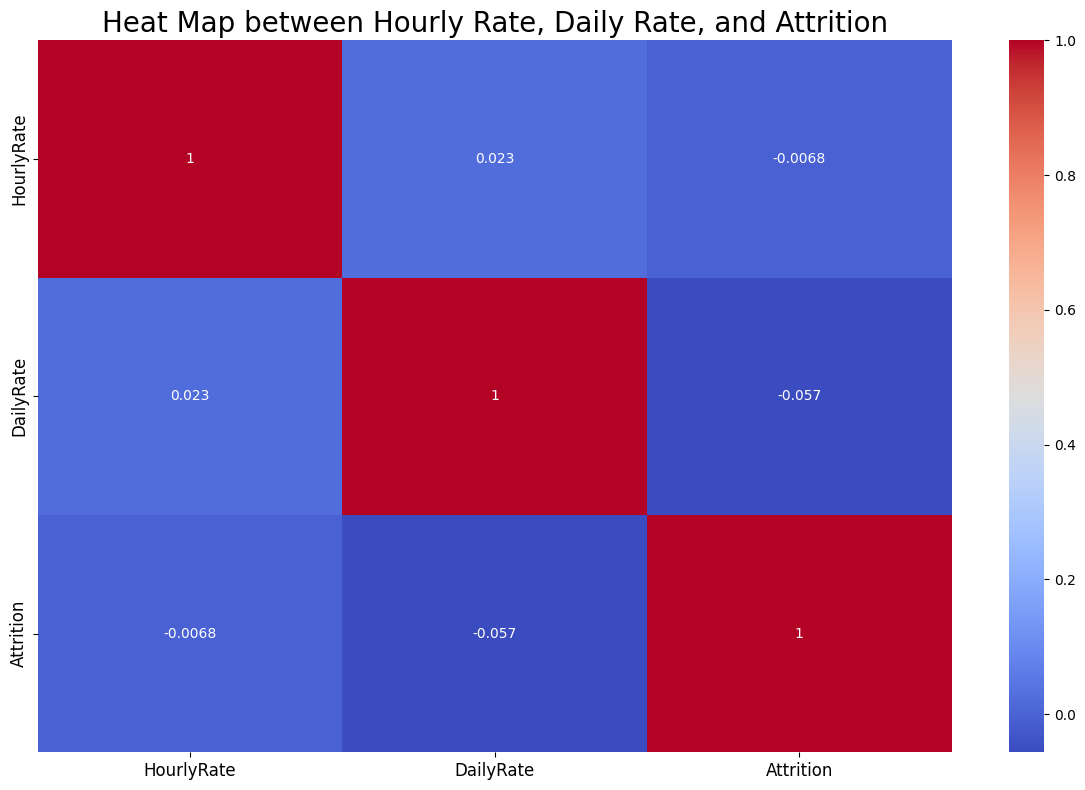

In [56]:
fig, ax = plt.subplots()

ax.set_title("Heat Map between Hourly Rate, Daily Rate, and Attrition", fontsize=20)
rate_df = df[["HourlyRate", "DailyRate"]].join(attrition_series)

sns.heatmap(rate_df.corr(), ax=ax, cmap="coolwarm", annot=True)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()
plt.close()

In [57]:
q = calculate_q_cuts("HourlyRate")

hourly_rate_series, hourly_rate_edges = pd.qcut(
    df["HourlyRate"], 
    q=q, 
    labels=np.arange(q), 
    retbins=True
)

hourly_rate_bins = {}
for x in np.arange(0, len(hourly_rate_edges) - 1):
    left_bound = float(hourly_rate_edges[x])
    right_bound = float(hourly_rate_edges[x + 1])

    hourly_rate_bins[f"hourly_rate_{x}"] = (left_bound, right_bound)

hourly_rate_bins

{'hourly_rate_0': (30.0, 37.0),
 'hourly_rate_1': (37.0, 44.0),
 'hourly_rate_2': (44.0, 50.0),
 'hourly_rate_3': (50.0, 56.0),
 'hourly_rate_4': (56.0, 62.0),
 'hourly_rate_5': (62.0, 70.0),
 'hourly_rate_6': (70.0, 76.0),
 'hourly_rate_7': (76.0, 82.0),
 'hourly_rate_8': (82.0, 88.0),
 'hourly_rate_9': (88.0, 95.0),
 'hourly_rate_10': (95.0, 100.0)}

/var/folders/w3/znbxr0vn1f55dpxxjj00nqq80000gq/T/ipykernel_86323/765131643.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_agg_df = temp_df.groupby(target_category).agg(


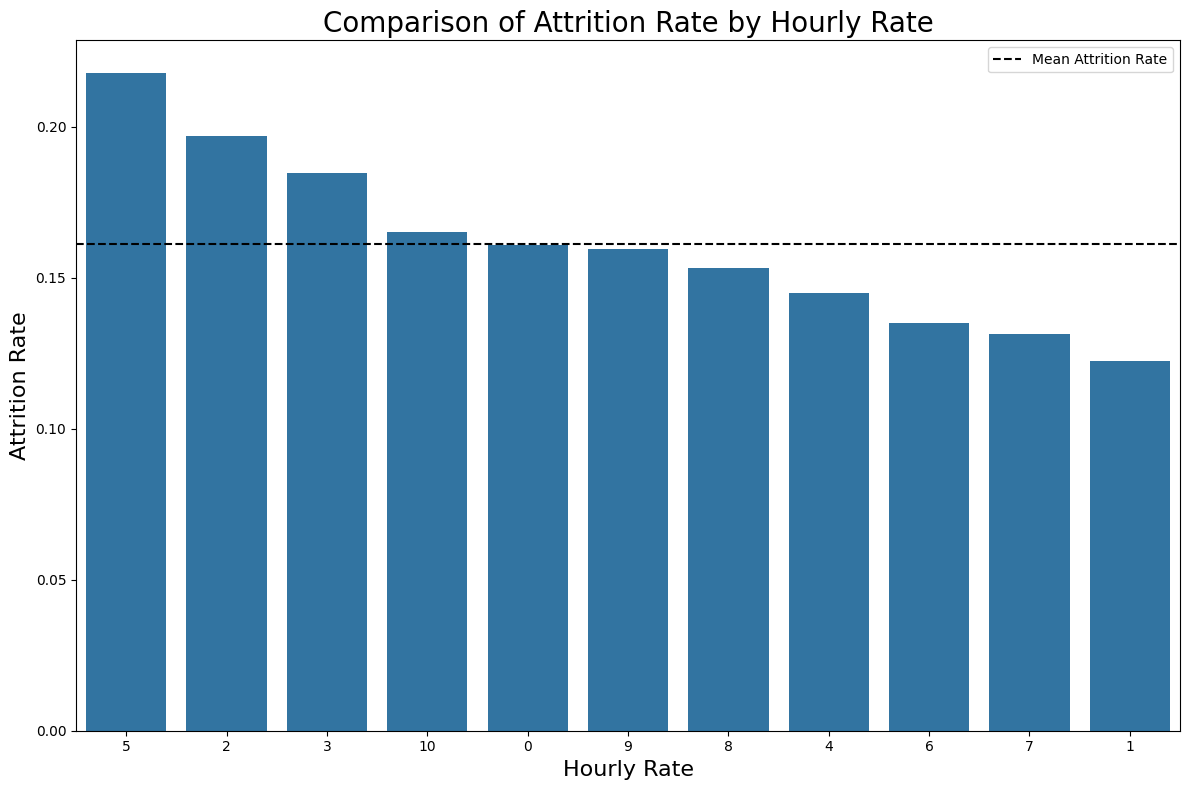

In [58]:
generate_barplot(hourly_rate_series)

In [59]:
hourly_chi2_df = run_chi2_test(hourly_rate_series)
hourly_labels = list(hourly_chi2_df.index)

Chi-square statistic: 8.62185336963068, p-value: 0.5683269659534141
9 of 11 to potentially group into OTHER


In [60]:
hourly_rate_series = impute_other_in_field(hourly_rate_series, hourly_labels)
run_chi2_test(hourly_rate_series)

Chi-square statistic: 5.07479479556664, p-value: 0.07907192499175261
1 of 3 to potentially group into OTHER


Attrition        0         1
HourlyRate                  
OTHER       0.0917 -0.209159

## Job Involvment, Job Level
I can see some level of involement here, but I cannot decide how to interpret.

In [61]:
df[["JobLevel", "JobInvolvement"]].value_counts().sort_index()

JobLevel  JobInvolvement
1         1                  30
          2                 137
          3                 318
          4                  58
2         1                  35
          2                 128
          3                 317
          4                  54
3         1                  10
          2                  66
          3                 128
          4                  14
4         1                   3
          2                  27
          3                  62
          4                  14
5         1                   5
          2                  17
          3                  43
          4                   4
Name: count, dtype: int64

In [62]:
job_level_series = df["JobLevel"]
job_level_df = run_chi2_test(job_level_series)
job_level_labels = list(job_level_df.index)
job_level_series = impute_other_in_field(job_level_series, job_level_labels)

Chi-square statistic: 72.5290131066739, p-value: 6.634684715458957e-15
1 of 5 to potentially group into OTHER


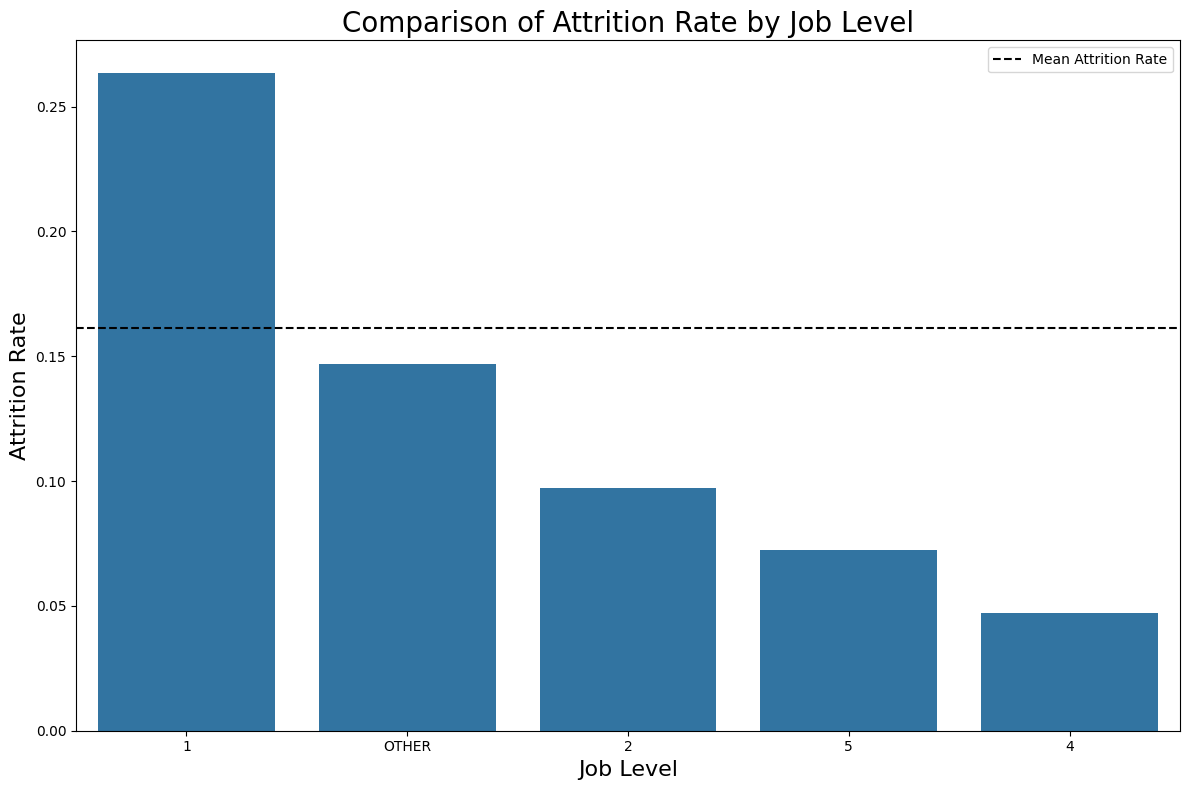

In [63]:
generate_barplot(job_level_series)

In [64]:
job_inv_series = df["JobInvolvement"]
job_inv_series.value_counts()

JobInvolvement
3    868
2    375
4    144
1     83
Name: count, dtype: int64

In [65]:
run_chi2_test(job_inv_series)

Chi-square statistic: 28.492021234659283, p-value: 2.863180636713418e-06
0 of 4 to potentially group into OTHER


Empty DataFrame
Columns: [0, 1]
Index: []

## Job Satisfaction

In [66]:
job_sat_series = df["JobSatisfaction"]
job_sat_series.value_counts()

JobSatisfaction
4    459
3    442
1    289
2    280
Name: count, dtype: int64

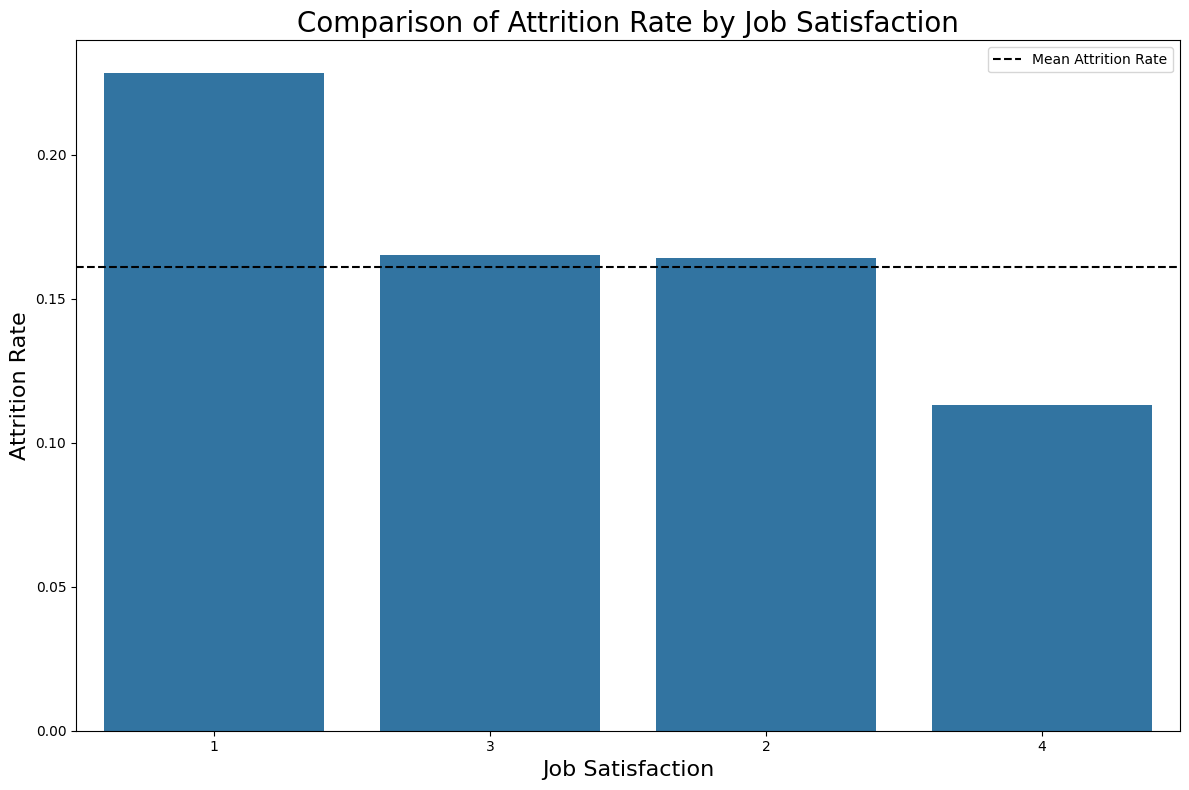

In [67]:
generate_barplot(job_sat_series)

In [68]:
job_sat_df = run_chi2_test(job_sat_series)
job_sat_labels = list(job_sat_df.index)
job_sat_series = impute_other_in_field(job_sat_series, job_sat_labels)

Chi-square statistic: 17.505077010348, p-value: 0.0005563004510387556
2 of 4 to potentially group into OTHER


In [69]:
run_chi2_test(job_sat_series)

Chi-square statistic: 17.504111730455506, p-value: 0.00015813588463301317
1 of 3 to potentially group into OTHER


Attrition               0         1
JobSatisfaction                    
OTHER           -0.105487  0.240606

## Monthly Income

In [70]:
df["MonthlyIncome"].value_counts()

MonthlyIncome
2342     4
6142     3
2741     3
2559     3
2610     3
        ..
7104     1
2773     1
19513    1
3447     1
4404     1
Name: count, Length: 1349, dtype: int64

In [71]:
df["MonthlyIncome"].describe()

count     1470.000000
mean      6502.931293
std       4707.956783
min       1009.000000
25%       2911.000000
50%       4919.000000
75%       8379.000000
max      19999.000000
Name: MonthlyIncome, dtype: float64

In [72]:
monthly_income_series = df['MonthlyIncome']

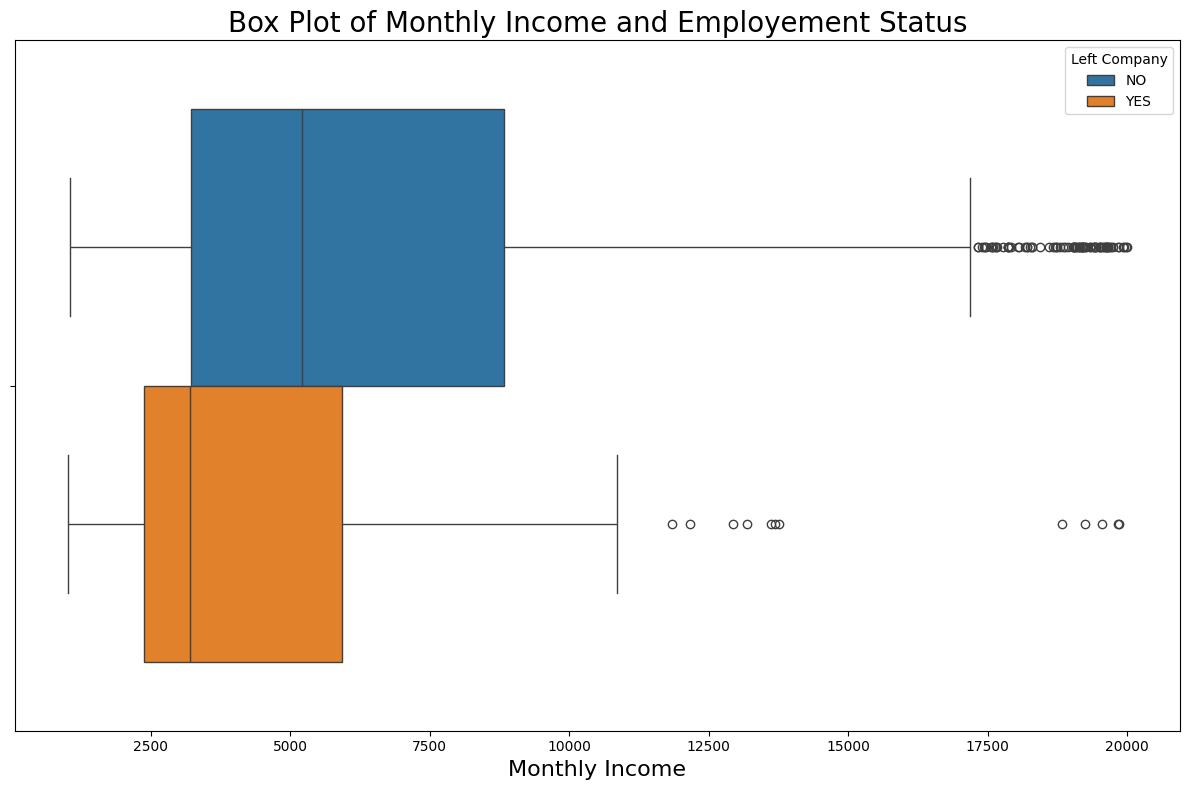

In [73]:
labels = ["NO", "YES"]

fig, ax = plt.subplots()

ax.set_title("Box Plot of Monthly Income and Employement Status", fontsize=20)

sns.boxplot(x=monthly_income_series, hue=attrition_series)

ax.set_xlabel("Monthly Income", fontsize=16)

ax.legend(title="Left Company", labels=labels)

plt.tight_layout()
plt.show()
plt.close()

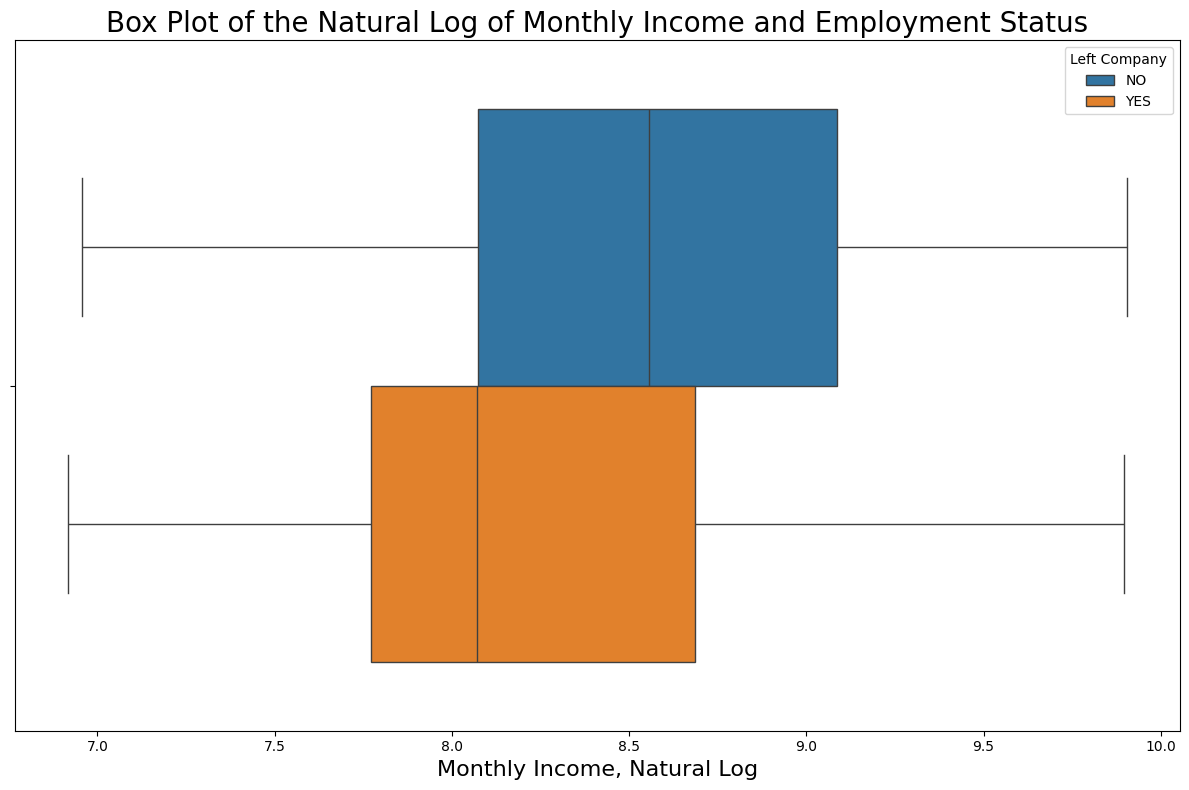

In [74]:
log_monthly_income_series = np.log(monthly_income_series)

labels = ["NO", "YES"]

fig, ax = plt.subplots()

ax.set_title("Box Plot of the Natural Log of Monthly Income and Employment Status", fontsize=20)

sns.boxplot(x=log_monthly_income_series, hue=attrition_series)

ax.set_xlabel("Monthly Income, Natural Log", fontsize=16)

ax.legend(title="Left Company", labels=labels)

plt.tight_layout()
plt.show()
plt.close()

In [75]:
data_range = log_monthly_income_series.max() - log_monthly_income_series.min()
iqr = log_monthly_income_series.quantile(0.75) - log_monthly_income_series.quantile(0.25)
bin_width = 2 * iqr * (len(df) ** (-1/3))
q = int(data_range / bin_width)

log_monthly_binned, log_monthly_edges = pd.qcut(
    log_monthly_income_series, q=q, retbins=True, labels=np.arange(q)
)

log_monthly_bins = {}

for x in np.arange(0, len(log_monthly_edges) - 1):
    left_bound = float(log_monthly_edges[x])
    right_bound = float(log_monthly_edges[x + 1])

    log_monthly_bins[f"log_monthly_income_{x}"] = (left_bound, right_bound)

log_monthly_bins

{'log_monthly_income_0': (6.9167150203536085, 7.674181552038936),
 'log_monthly_income_1': (7.674181552038936, 7.774120119199422),
 'log_monthly_income_2': (7.774120119199422, 7.884529376462691),
 'log_monthly_income_3': (7.884529376462691, 7.976251943745623),
 'log_monthly_income_4': (7.976251943745623, 8.144715457389577),
 'log_monthly_income_5': (8.144715457389577, 8.301676699457326),
 'log_monthly_income_6': (8.301676699457326, 8.402972893888627),
 'log_monthly_income_7': (8.402972893888627, 8.500858036433769),
 'log_monthly_income_8': (8.500858036433769, 8.595079730073309),
 'log_monthly_income_9': (8.595079730073309, 8.712554071972995),
 'log_monthly_income_10': (8.712554071972995, 8.822018106435475),
 'log_monthly_income_11': (8.822018106435475, 9.03348383324469),
 'log_monthly_income_12': (9.03348383324469, 9.225158828360959),
 'log_monthly_income_13': (9.225158828360959, 9.481702484664618),
 'log_monthly_income_14': (9.481702484664618, 9.747038250012414),
 'log_monthly_income_

In [76]:
log_monthly_df = run_chi2_test(log_monthly_binned)
log_monthly_labels = list(log_monthly_df.index)
log_monthly_binned = impute_other_in_field(log_monthly_binned, log_monthly_labels)

Chi-square statistic: 83.44461597941053, p-value: 1.6289649148372896e-11
5 of 16 to potentially group into OTHER


In [77]:
run_chi2_test(log_monthly_binned)

Chi-square statistic: 81.90493171763829, p-value: 6.311620214667837e-13
1 of 12 to potentially group into OTHER


Attrition            0         1
MonthlyIncome                   
OTHER          0.14494 -0.330594

## Number of Companies Worked At

In [78]:
df["NumCompaniesWorked"].value_counts()

NumCompaniesWorked
1    521
0    197
3    159
2    146
4    139
7     74
6     70
5     63
9     52
8     49
Name: count, dtype: int64

In [79]:
num_comp_series = df["NumCompaniesWorked"]

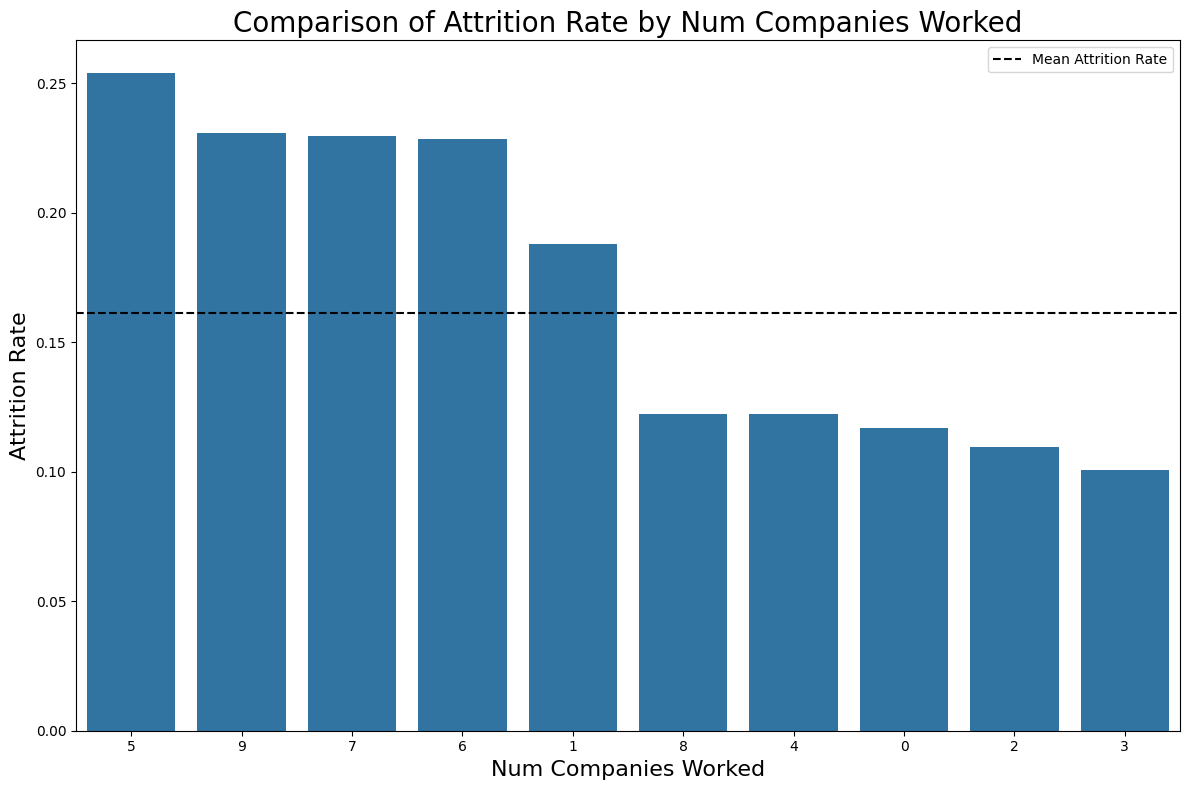

In [80]:
generate_barplot(num_comp_series)

In [81]:
num_comp_df = run_chi2_test(num_comp_series)
num_comp_labels = list(num_comp_df.index)
num_comp_series = impute_other_in_field(num_comp_series, num_comp_labels)

Chi-square statistic: 25.744404417151316, p-value: 0.0022491782946850525
1 of 10 to potentially group into OTHER


## Overtime
Yes/No on whether they receive ovetime or not.

In [82]:
df["OverTime"].value_counts()

OverTime
No     1054
Yes     416
Name: count, dtype: int64

In [83]:
overtime_map = {"No": 0, "Yes": 1}
overtime_series = df["OverTime"].map(overtime_map)

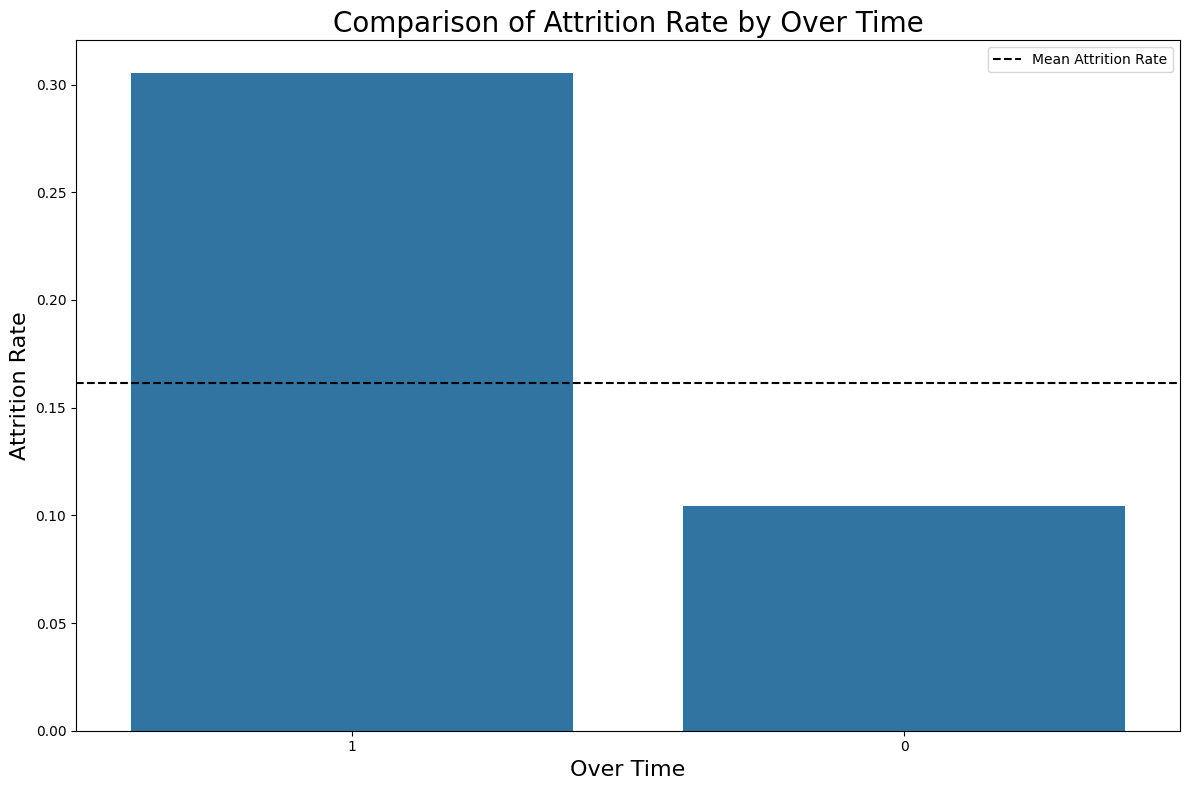

In [84]:
generate_barplot(overtime_series)

In [85]:
run_chi2_test(overtime_series)

Chi-square statistic: 87.56429365828768, p-value: 8.15842372153832e-21
0 of 2 to potentially group into OTHER


Empty DataFrame
Columns: [0, 1]
Index: []

## Percent Salary Hike

In [86]:
df["PercentSalaryHike"].value_counts()

PercentSalaryHike
11    210
13    209
14    201
12    198
15    101
18     89
17     82
16     78
19     76
22     56
20     55
21     48
23     28
24     21
25     18
Name: count, dtype: int64

In [87]:
salary_hike_series = df["PercentSalaryHike"]

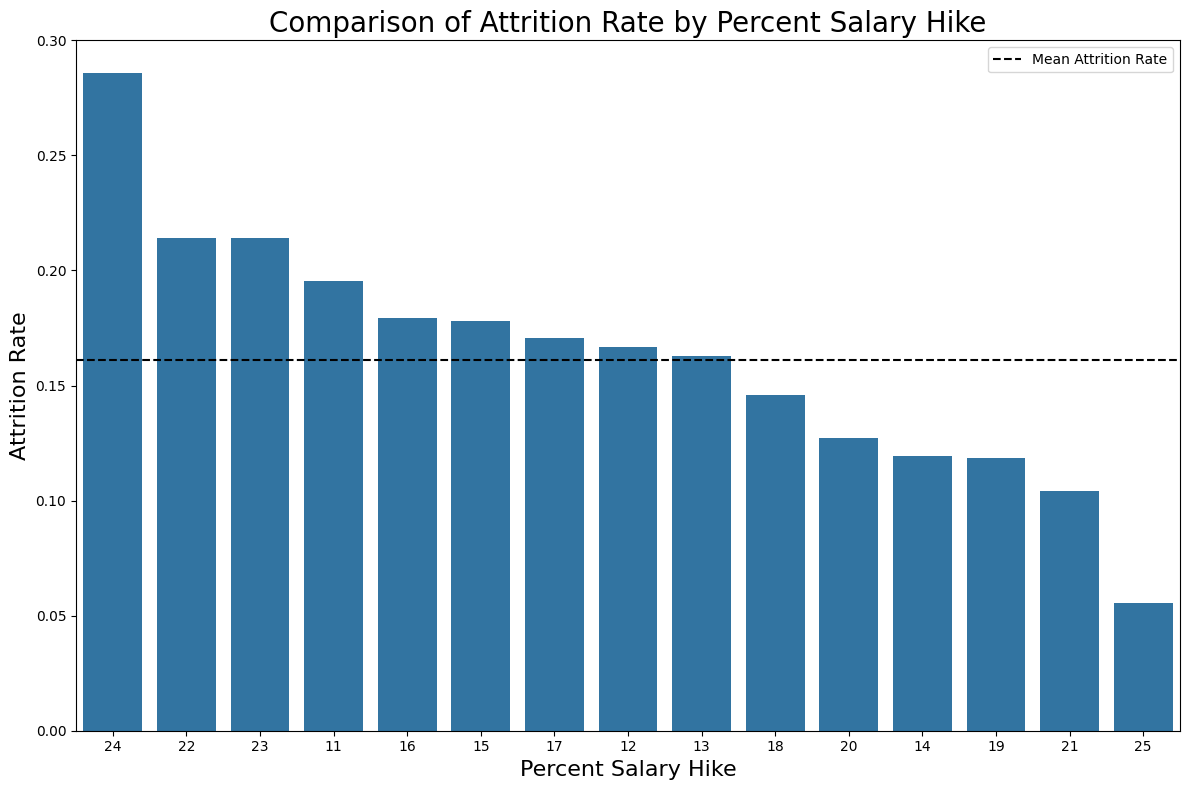

In [88]:
generate_barplot(salary_hike_series)

In [89]:
salary_hike_df = run_chi2_test(salary_hike_series)
salary_hike_labels = list(salary_hike_df.index)
salary_hike_series = impute_other_in_field(salary_hike_series, salary_hike_labels)

Chi-square statistic: 13.352748467459849, p-value: 0.4989552229272689
11 of 15 to potentially group into OTHER


In [90]:
run_chi2_test(salary_hike_series)

Chi-square statistic: 8.291338014859942, p-value: 0.08147055470350142
1 of 5 to potentially group into OTHER


Attrition                 0         1
PercentSalaryHike                    
OTHER             -0.018838  0.042969

In [91]:
df["PerformanceRating"].value_counts()

PerformanceRating
3    1244
4     226
Name: count, dtype: int64

In [92]:
perf_rating_series = df["PerformanceRating"]

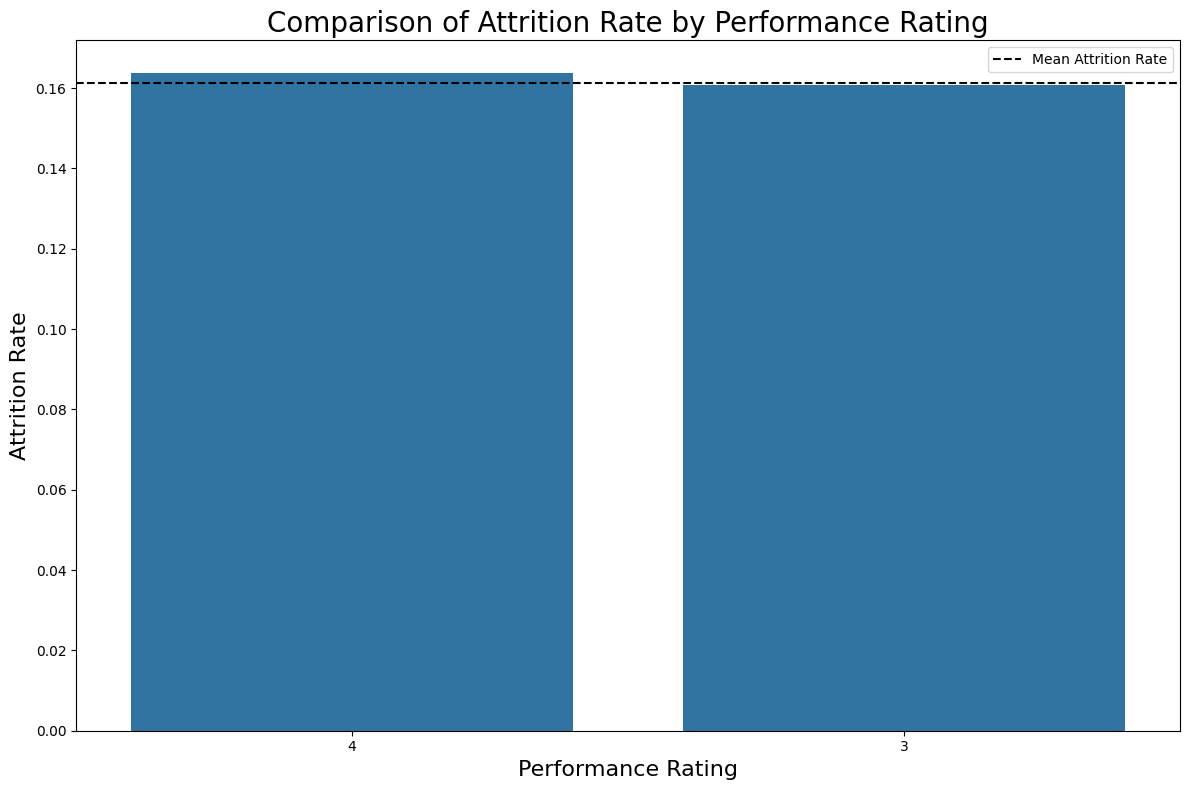

In [93]:
generate_barplot(perf_rating_series)

In [94]:
run_chi2_test(perf_rating_series)

Chi-square statistic: 0.00015475439428271534, p-value: 0.9900745465934576
2 of 2 to potentially group into OTHER


Attrition                 0         1
PerformanceRating                    
3                  0.017437 -0.039773
4                 -0.040911  0.093313

## Standard Hours

In [95]:
df["StandardHours"].value_counts()

StandardHours
80    1470
Name: count, dtype: int64

## Stock Options Level

In [96]:
df["StockOptionLevel"].value_counts()

StockOptionLevel
0    631
1    596
2    158
3     85
Name: count, dtype: int64

In [97]:
stock_opt_series = df["StockOptionLevel"]

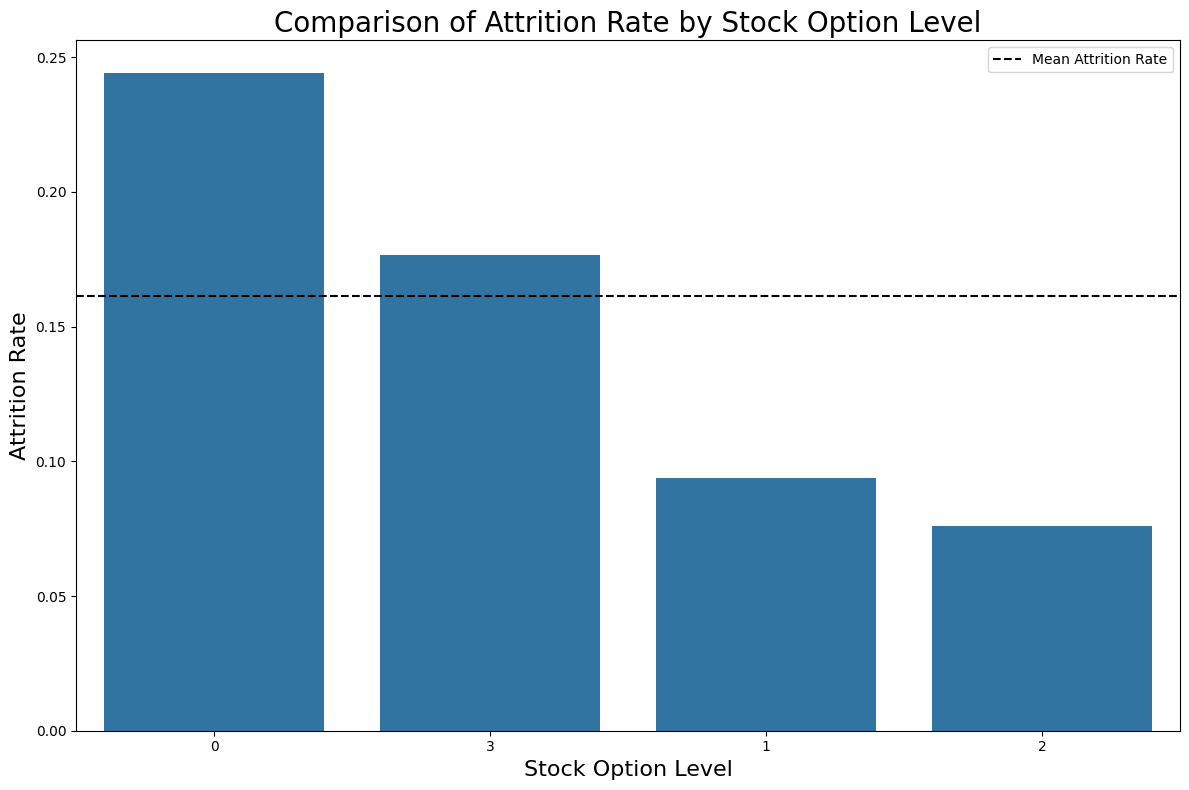

In [98]:
generate_barplot(stock_opt_series)

In [99]:
stock_opt_df = run_chi2_test(stock_opt_series)
stock_opt_labels = list(stock_opt_df.index)
stock_opt_series = impute_other_in_field(stock_opt_series, stock_opt_labels)

Chi-square statistic: 60.59830108612225, p-value: 4.379390336108353e-13
1 of 4 to potentially group into OTHER


## Hours Spent Training

In [100]:
df["TrainingTimesLastYear"].value_counts()

TrainingTimesLastYear
2    547
3    491
4    123
5    119
1     71
6     65
0     54
Name: count, dtype: int64

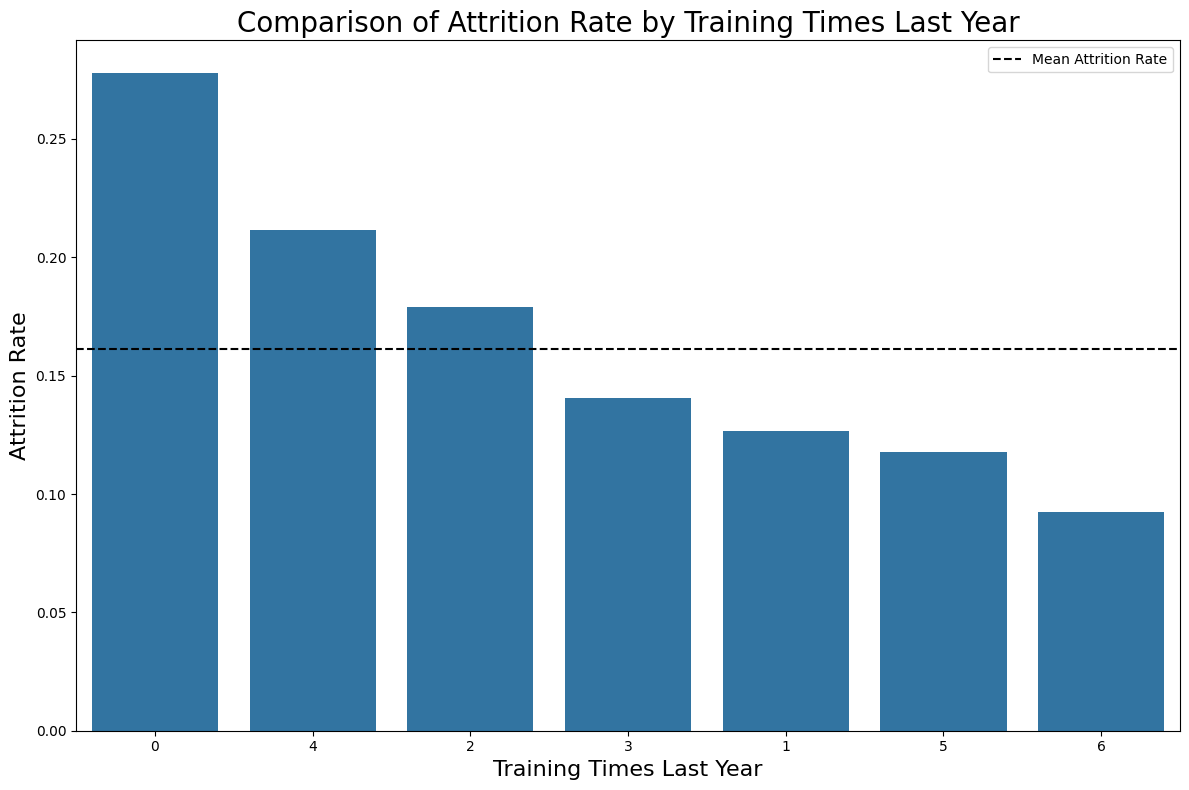

In [101]:
training_series = df["TrainingTimesLastYear"]
generate_barplot(training_series)

In [102]:
training_df = run_chi2_test(training_series)
training_labels = list(training_df.index)
training_series = impute_other_in_field(training_series, training_labels)

Chi-square statistic: 15.146451478483337, p-value: 0.019147729860095133
1 of 7 to potentially group into OTHER


## Work Life Balance

In [103]:
df["WorkLifeBalance"].value_counts()

WorkLifeBalance
3    893
2    344
4    153
1     80
Name: count, dtype: int64

In [104]:
work_life_bal_series = df["WorkLifeBalance"]

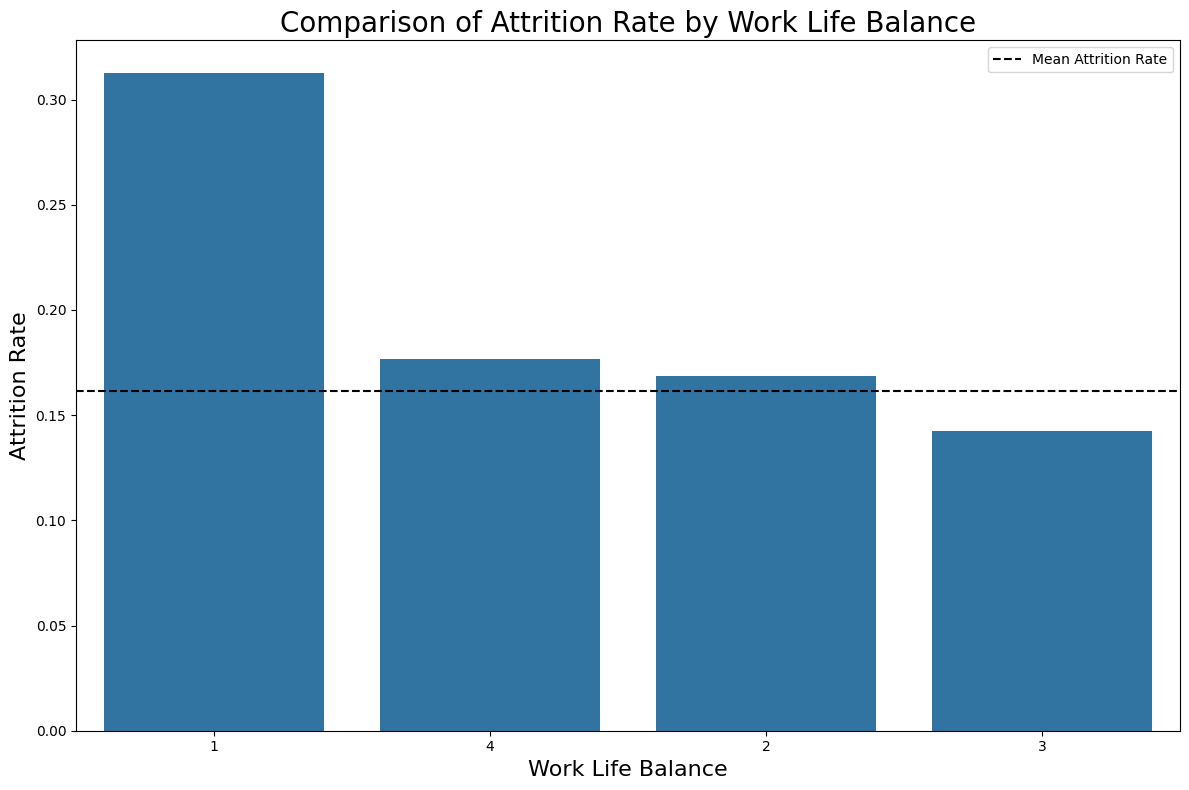

In [105]:
generate_barplot(work_life_bal_series)

In [106]:
bal_df = run_chi2_test(work_life_bal_series)
bal_list = list(bal_df.index)
work_life_bal_series = impute_other_in_field(work_life_bal_series, bal_list)
run_chi2_test(work_life_bal_series)

Chi-square statistic: 16.3250970916474, p-value: 0.0009725698845348821
2 of 4 to potentially group into OTHER
Chi-square statistic: 16.276644426888097, p-value: 0.00029212691391029876
1 of 3 to potentially group into OTHER


Attrition               0         1
WorkLifeBalance                    
OTHER           -0.238592  0.544205

In [107]:
years_at_co_series = df["YearsAtCompany"]
years_at_co_series.value_counts()

YearsAtCompany
5     196
1     171
3     128
2     127
10    120
4     110
7      90
9      82
8      80
6      76
0      44
11     32
20     27
13     24
15     20
14     18
22     15
12     14
21     14
18     13
16     12
19     11
17      9
24      6
33      5
25      4
26      4
31      3
32      3
27      2
36      2
29      2
23      2
37      1
40      1
34      1
30      1
Name: count, dtype: int64

In [108]:
sorted(years_at_co_series.value_counts().index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 40]

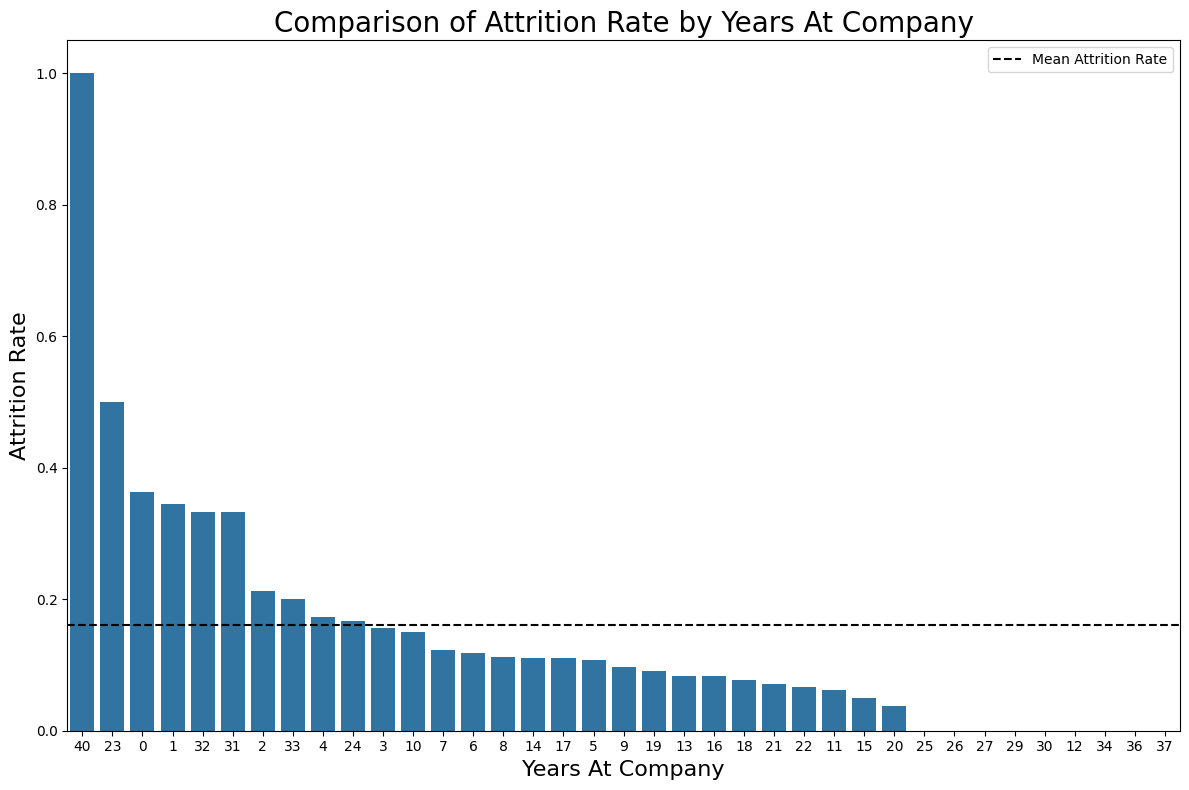

In [109]:
generate_barplot(years_at_co_series)

In [110]:
sorted(list(years_at_co_series.value_counts().index))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 40]

<Axes: ylabel='YearsAtCompany'>

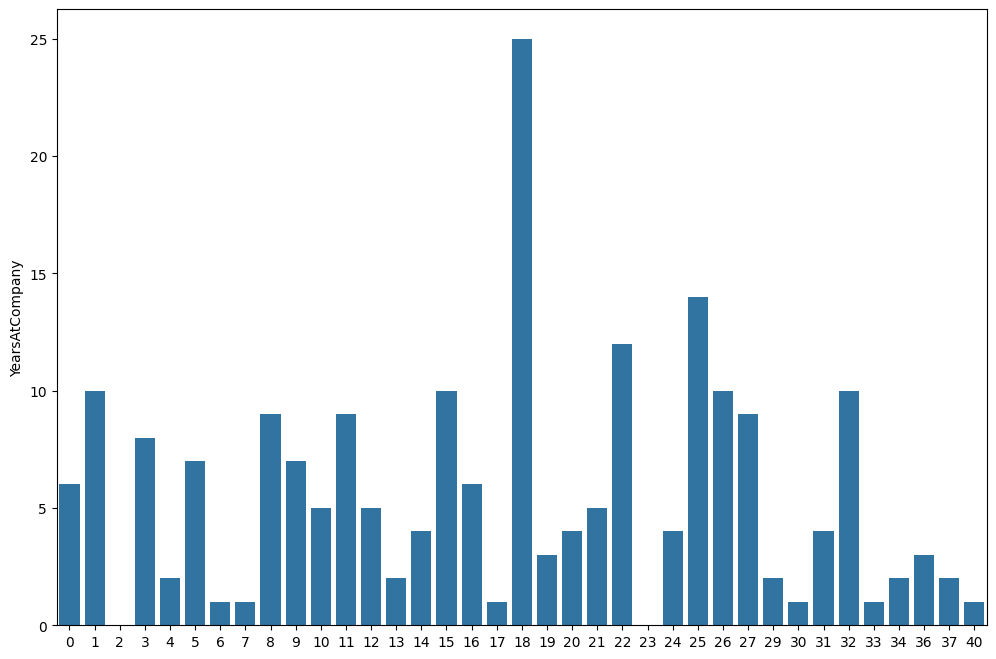

In [111]:
order = sorted(list(years_at_co_series.value_counts().index))
sns.barplot(data=years_at_co_series, order=order)

In [112]:
bins = [-1, 2, 5, 10, 15, 20, 25, float('inf')]  # Adjust as needed
labels = [
    '0_2_years', 
    '3_5_years', 
    '6_10_years', 
    '11_15_years', 
    '16_20_years', 
    '21_25_years', 
    '26Plus_years'
]

years_at_co_binned = pd.cut(years_at_co_series, bins=bins, labels=labels)


/var/folders/w3/znbxr0vn1f55dpxxjj00nqq80000gq/T/ipykernel_86323/765131643.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_agg_df = temp_df.groupby(target_category).agg(


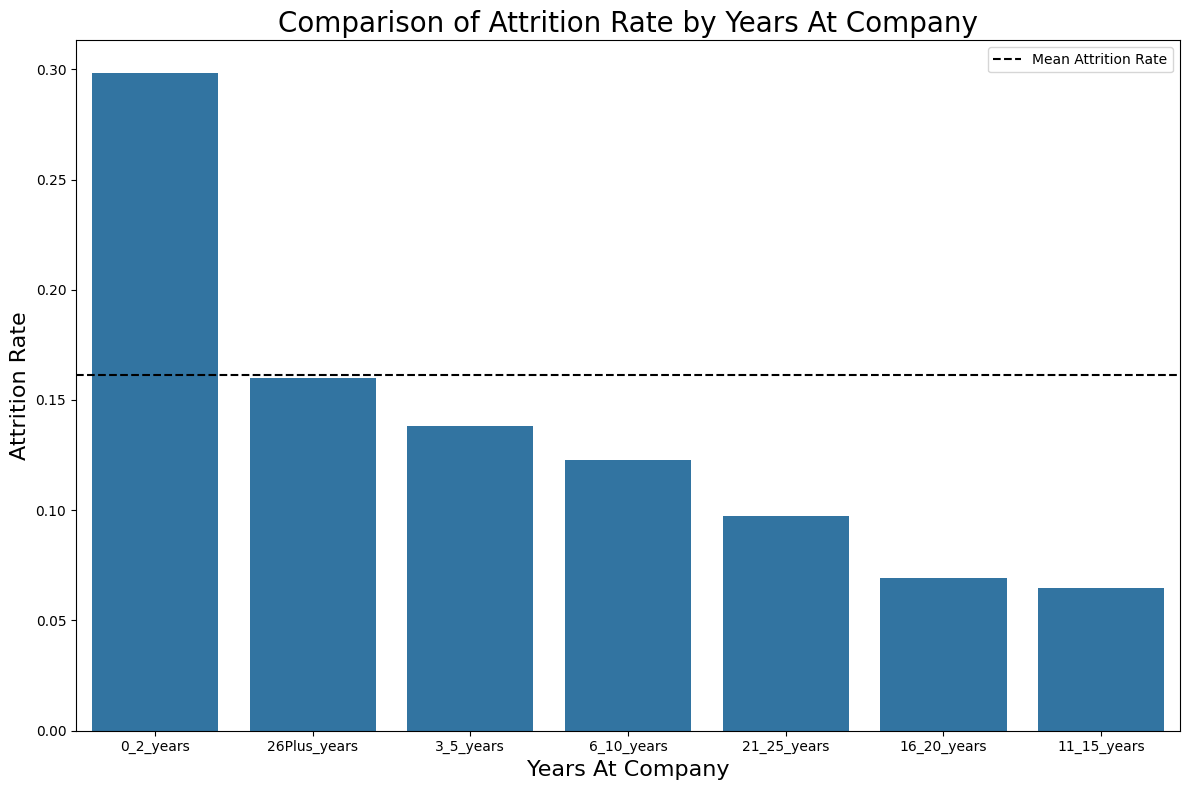

In [113]:
generate_barplot(years_at_co_binned)

In [114]:
years_at_co_binned.isna()

0       False
1       False
2       False
3       False
4       False
        ...  
1465    False
1466    False
1467    False
1468    False
1469    False
Name: YearsAtCompany, Length: 1470, dtype: bool

In [115]:
df["YearsAtCompany"]

0        6
1       10
2        0
3        8
4        2
        ..
1465     5
1466     7
1467     6
1468     9
1469     4
Name: YearsAtCompany, Length: 1470, dtype: int64

In [116]:
years_df = run_chi2_test(years_at_co_binned)
years_labels = list(years_df.index)
years_at_co_binned = impute_other_in_field(years_at_co_binned, years_labels)
run_chi2_test(years_at_co_binned)

Chi-square statistic: 67.21218557264886, p-value: 1.5229897352143528e-12
1 of 7 to potentially group into OTHER
Chi-square statistic: 67.21218557264886, p-value: 1.5229897352143528e-12
1 of 7 to potentially group into OTHER


Attrition              0         1
YearsAtCompany                    
OTHER           0.006685 -0.015248

/var/folders/w3/znbxr0vn1f55dpxxjj00nqq80000gq/T/ipykernel_86323/765131643.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_agg_df = temp_df.groupby(target_category).agg(


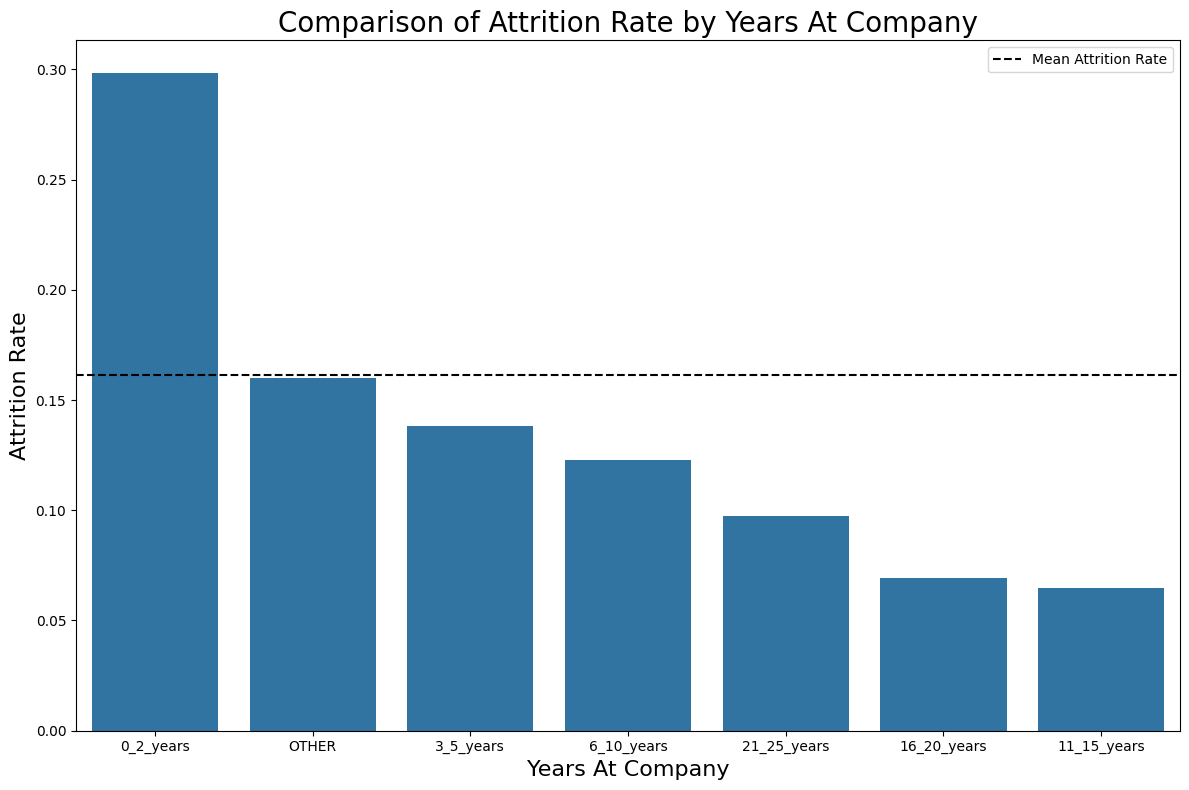

In [117]:
generate_barplot(years_at_co_binned)

## Years at Current Role

In [118]:
time_in_curr_role_series = df["YearsInCurrentRole"]
time_in_curr_role_series.value_counts()

YearsInCurrentRole
2     372
0     244
7     222
3     135
4     104
8      89
9      67
1      57
6      37
5      36
10     29
11     22
13     14
14     11
12     10
15      8
16      7
17      4
18      2
Name: count, dtype: int64

<Axes: ylabel='YearsInCurrentRole'>

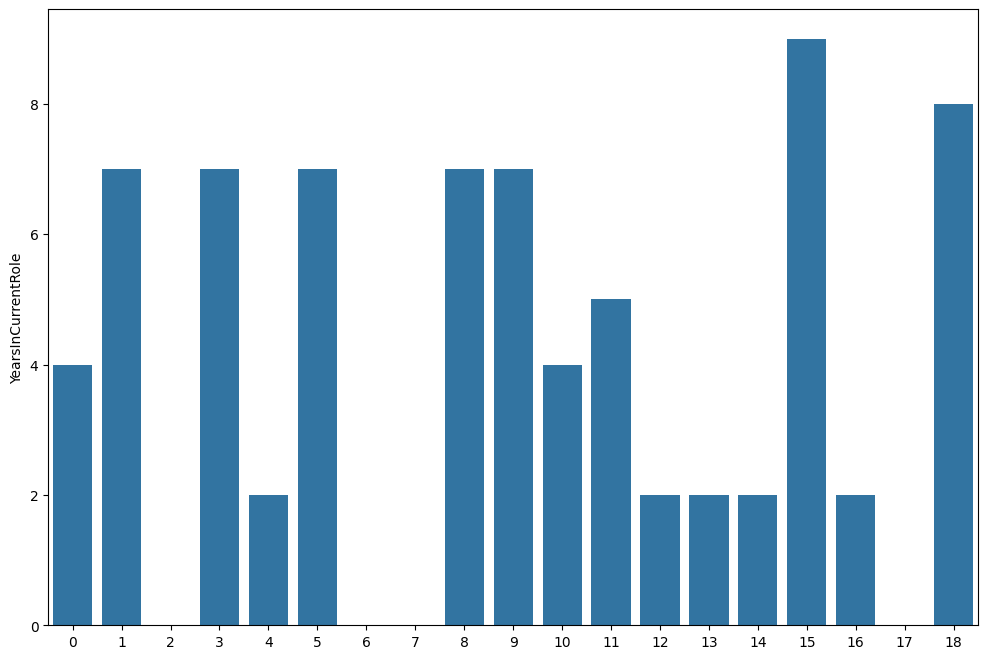

In [119]:
order = sorted(time_in_curr_role_series.value_counts().index)
sns.barplot(time_in_curr_role_series, order=order)

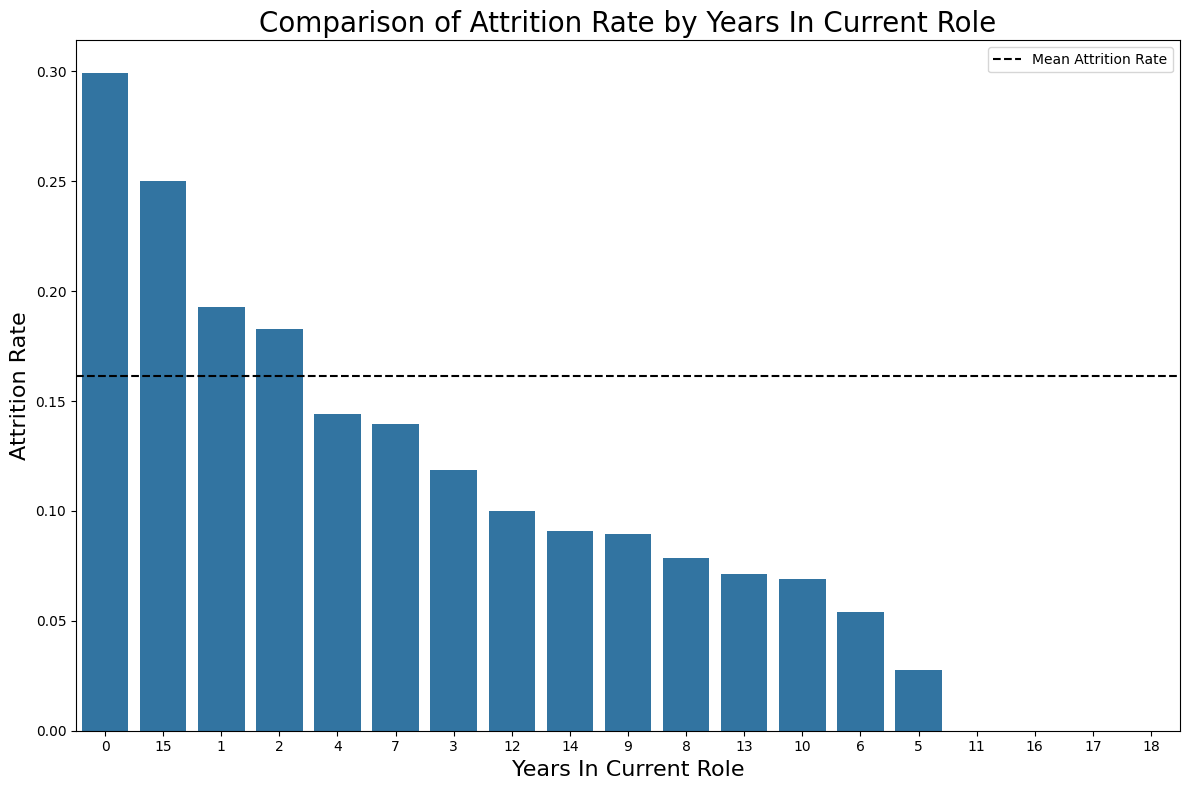

In [120]:
generate_barplot(time_in_curr_role_series)

/var/folders/w3/znbxr0vn1f55dpxxjj00nqq80000gq/T/ipykernel_86323/765131643.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_agg_df = temp_df.groupby(target_category).agg(


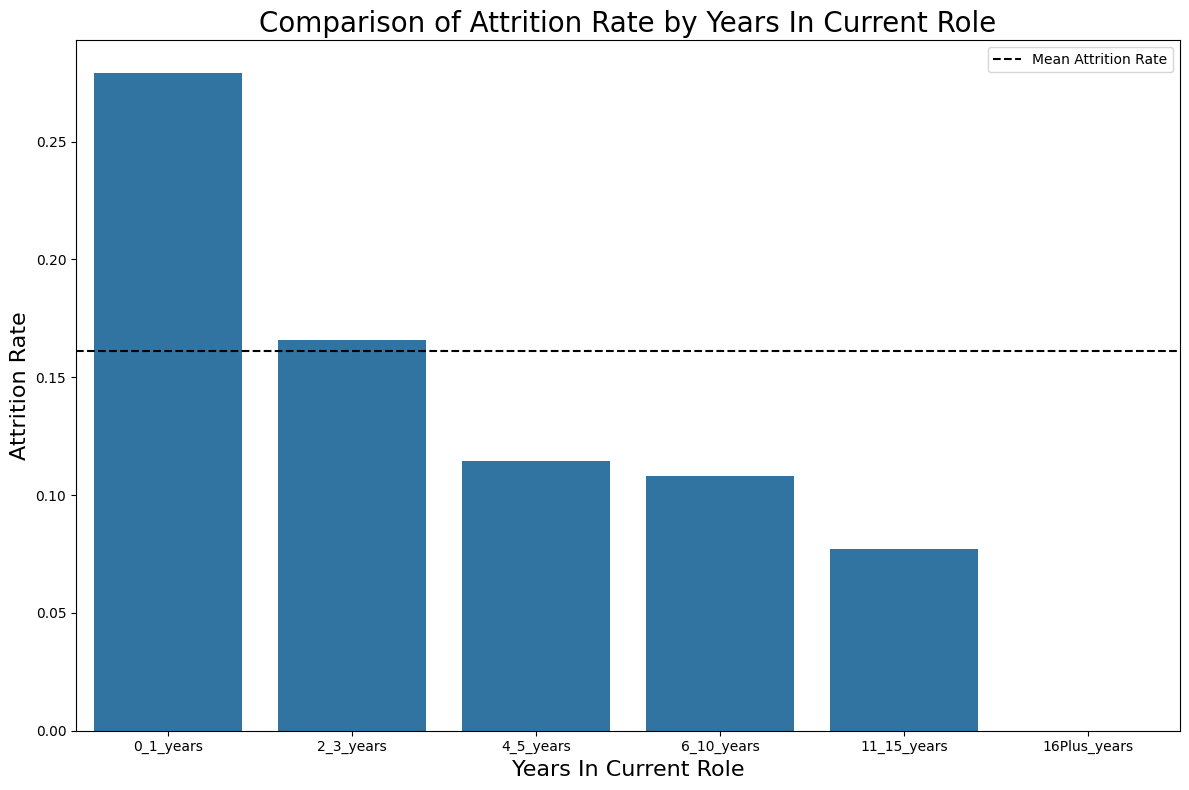

In [121]:
bins = [-1,1,3,5,10,15,np.inf]
labels = [
    "0_1_years",
    "2_3_years",
    "4_5_years",
    "6_10_years",
    "11_15_years",
    "16Plus_years"
]

years_in_role_binned = pd.cut(time_in_curr_role_series, bins=bins, labels=labels)
generate_barplot(years_in_role_binned)

In [122]:
years_in_role_df = run_chi2_test(years_in_role_binned)
years_in_role_labels = list(years_in_role_df.index)
years_in_role_binned = impute_other_in_field(years_in_role_binned, years_in_role_labels)

Chi-square statistic: 48.44440035161213, p-value: 2.8821934866486058e-09
1 of 6 to potentially group into OTHER


## Years Since Last Promotion

In [123]:
years_no_promo = df["YearsSinceLastPromotion"]
years_no_promo.value_counts()

YearsSinceLastPromotion
0     581
1     357
2     159
7      76
4      61
3      52
5      45
6      32
11     24
8      18
9      17
15     13
13     10
12     10
14      9
10      6
Name: count, dtype: int64

In [124]:
years_no_promo.describe()

count    1470.000000
mean        2.187755
std         3.222430
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        15.000000
Name: YearsSinceLastPromotion, dtype: float64

<Axes: xlabel='YearsSinceLastPromotion', ylabel='Count'>

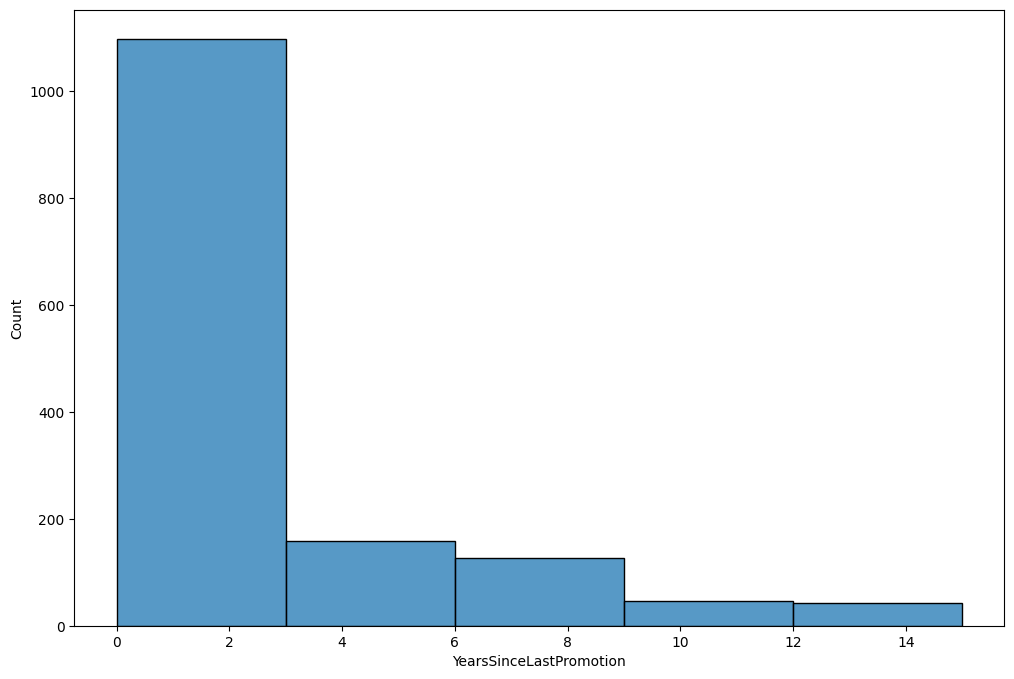

In [125]:
sns.histplot(years_no_promo, bins=5)

In [126]:
years_no_promo_df = run_chi2_test(years_no_promo)
years_no_promo_labels = list(years_no_promo_df.index)
years_no_promo = impute_other_in_field(years_no_promo, years_no_promo_labels)
run_chi2_test(years_no_promo)

Chi-square statistic: 21.844969938120684, p-value: 0.11193387671448668
9 of 16 to potentially group into OTHER
Chi-square statistic: 19.248551672421293, p-value: 0.00744336475655841
1 of 8 to potentially group into OTHER


Attrition                       0         1
YearsSinceLastPromotion                    
OTHER                   -0.187761  0.428265

In [127]:
years_w_manager_series = df["YearsWithCurrManager"]
years_w_manager_series.value_counts()

YearsWithCurrManager
2     344
0     263
7     216
3     142
8     107
4      98
1      76
9      64
5      31
6      29
10     27
11     22
12     18
13     14
17      7
15      5
14      5
16      2
Name: count, dtype: int64

<Axes: ylabel='YearsWithCurrManager'>

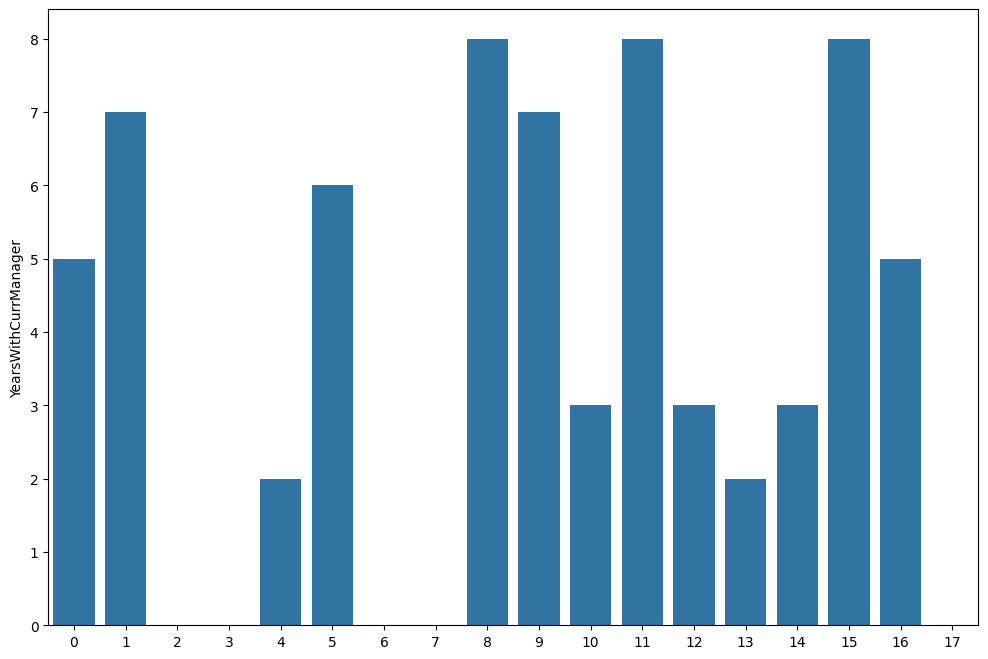

In [128]:
order = sorted(years_w_manager_series.value_counts().index)
sns.barplot(years_w_manager_series, order=order)

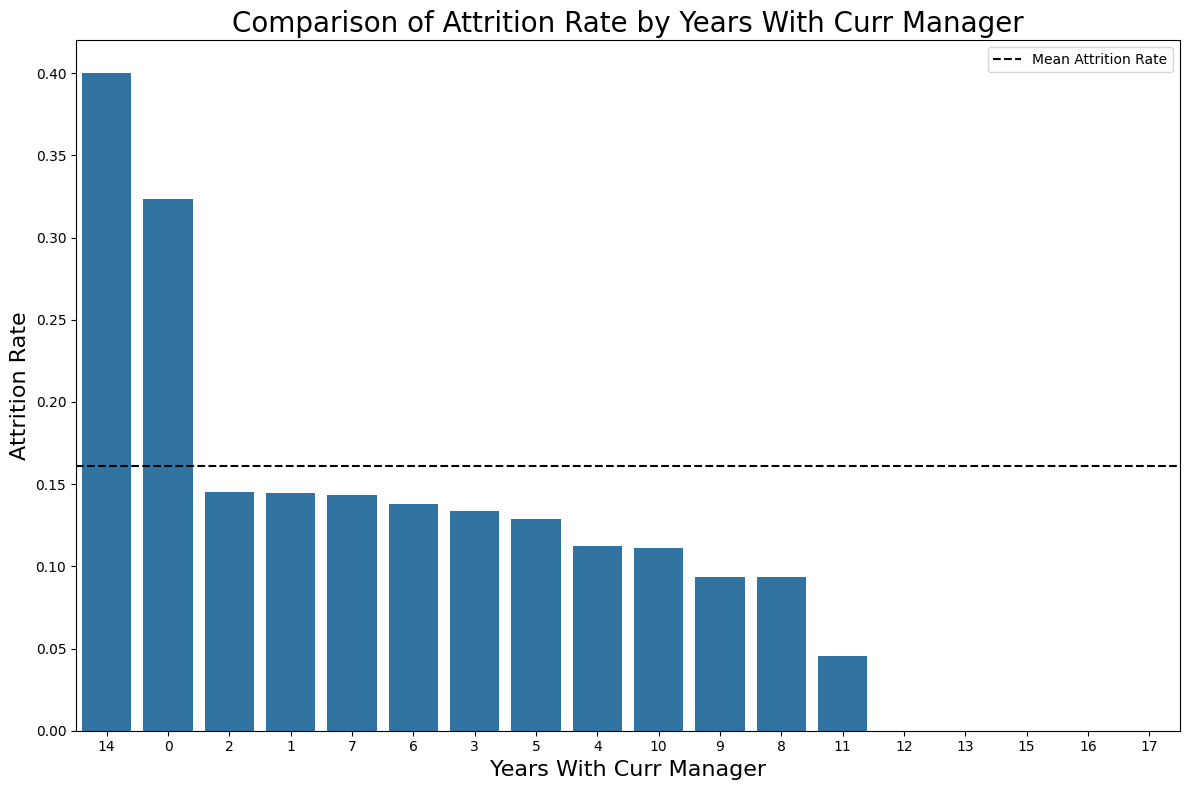

In [129]:
generate_barplot(years_w_manager_series)

In [130]:
years_w_manager_df = run_chi2_test(years_w_manager_series)
manager_labels = list(years_w_manager_df.index)
years_w_manager_series = impute_other_in_field(years_w_manager_series, manager_labels)
run_chi2_test(years_w_manager_series)

Chi-square statistic: 74.6171841152656, p-value: 3.408337118839609e-09
9 of 18 to potentially group into OTHER
Chi-square statistic: 73.26206824217108, p-value: 3.4792612765666427e-12
0 of 10 to potentially group into OTHER


Empty DataFrame
Columns: [0, 1]
Index: []

# XGBoost

## Assign Target Variable

In [131]:
y = attrition_series

## Build Dataframe of Predictive Features

In [132]:
# Combine series into a DataFrame
categorical_df = pd.concat(
    [
        business_travel_series,
        daily_rate_series,
        department_series,
        distance_series_binned,
        env_satisfaction_series,
        job_level_series,
        job_inv_series,
        job_sat_series,
        log_monthly_binned,
        num_comp_series,
        overtime_series,
        salary_hike_series,
        stock_opt_series,
        training_series,
        work_life_bal_series,
        years_at_co_binned,
        years_at_co_binned,
        years_in_role_binned,
        years_no_promo,
        years_w_manager_series
    ], 
    axis=1
)

# Convert column names to snake_case
pattern = r'(?<!^)([A-Z])'
repl = r'_\1'
category_names = [re.sub(pattern, repl, x).lower() for x in categorical_df.columns]
categorical_df.columns = category_names

# Convert all data to strings for compatibility with OneHotEncoder
categorical_df = categorical_df.astype(str)

# Loop through each categorical column and determine the baseline factor
baseline_factors = [
    determine_baseline_factor(category) for category in categorical_df.columns
]

# Initialize and apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
df_encoded = encoder.fit_transform(categorical_df)

# Retrieve encoded column names
encoded_columns = encoder.get_feature_names_out(categorical_df.columns)

# Create a DataFrame from the encoded data
X = pd.DataFrame(df_encoded, columns=encoded_columns)
X.sort_index(axis=1, ascending=True, inplace=True)

# Drop baseline columns from the encoded DataFrame
X.drop(columns=baseline_factors, inplace=True)

# Display the head of the resulting DataFrame
print(X.shape)
X.head()

(1470, 93)


business_travel_NON_TRAVEL  business_travel_TRAVEL_FREQUENTLY  \
0                         0.0                                0.0   
1                         0.0                                1.0   
2                         0.0                                0.0   
3                         0.0                                1.0   
4                         0.0                                0.0   

   daily_rate_0  daily_rate_1  daily_rate_8  \
0           0.0           0.0           0.0   
1           0.0           1.0           0.0   
2           0.0           0.0           0.0   
3           0.0           0.0           0.0   
4           0.0           0.0           0.0   

   department_RESEARCH_&_DEVELOPMENT  department_SALES  distance_from_home_0  \
0                                0.0               1.0                   1.0   
1                                1.0               0.0                   0.0   
2                                1.0               0.0                   1.0   
3                                1.0               0.0                   0.0   
4                                1.0               0.0                   1.0   

   distance_from_home_4  distance_from_home_5  ...  \
0                   0.0                   0.0  ...   
1                   1.0                   0.0  ...   
2                   0.0                   0.0  ...   
3                   0.0                   0.0  ...   
4                   0.0                   0.0  ...   

   years_since_last_promotion_8  years_with_curr_manager_0  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        0.0   

   years_with_curr_manager_11  years_with_curr_manager_12  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   years_with_curr_manager_13  years_with_curr_manager_14  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   years_with_curr_manager_17  years_with_curr_manager_4  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   years_with_curr_manager_8  years_with_curr_manager_9  
0                        0.0                        0.0  
1                        0.0                        0.0  
2                        0.0                        0.0  
3                        0.0                        0.0  
4                        0.0                        0.0  

[5 rows x 93 columns]

## Check for Multicollinearity

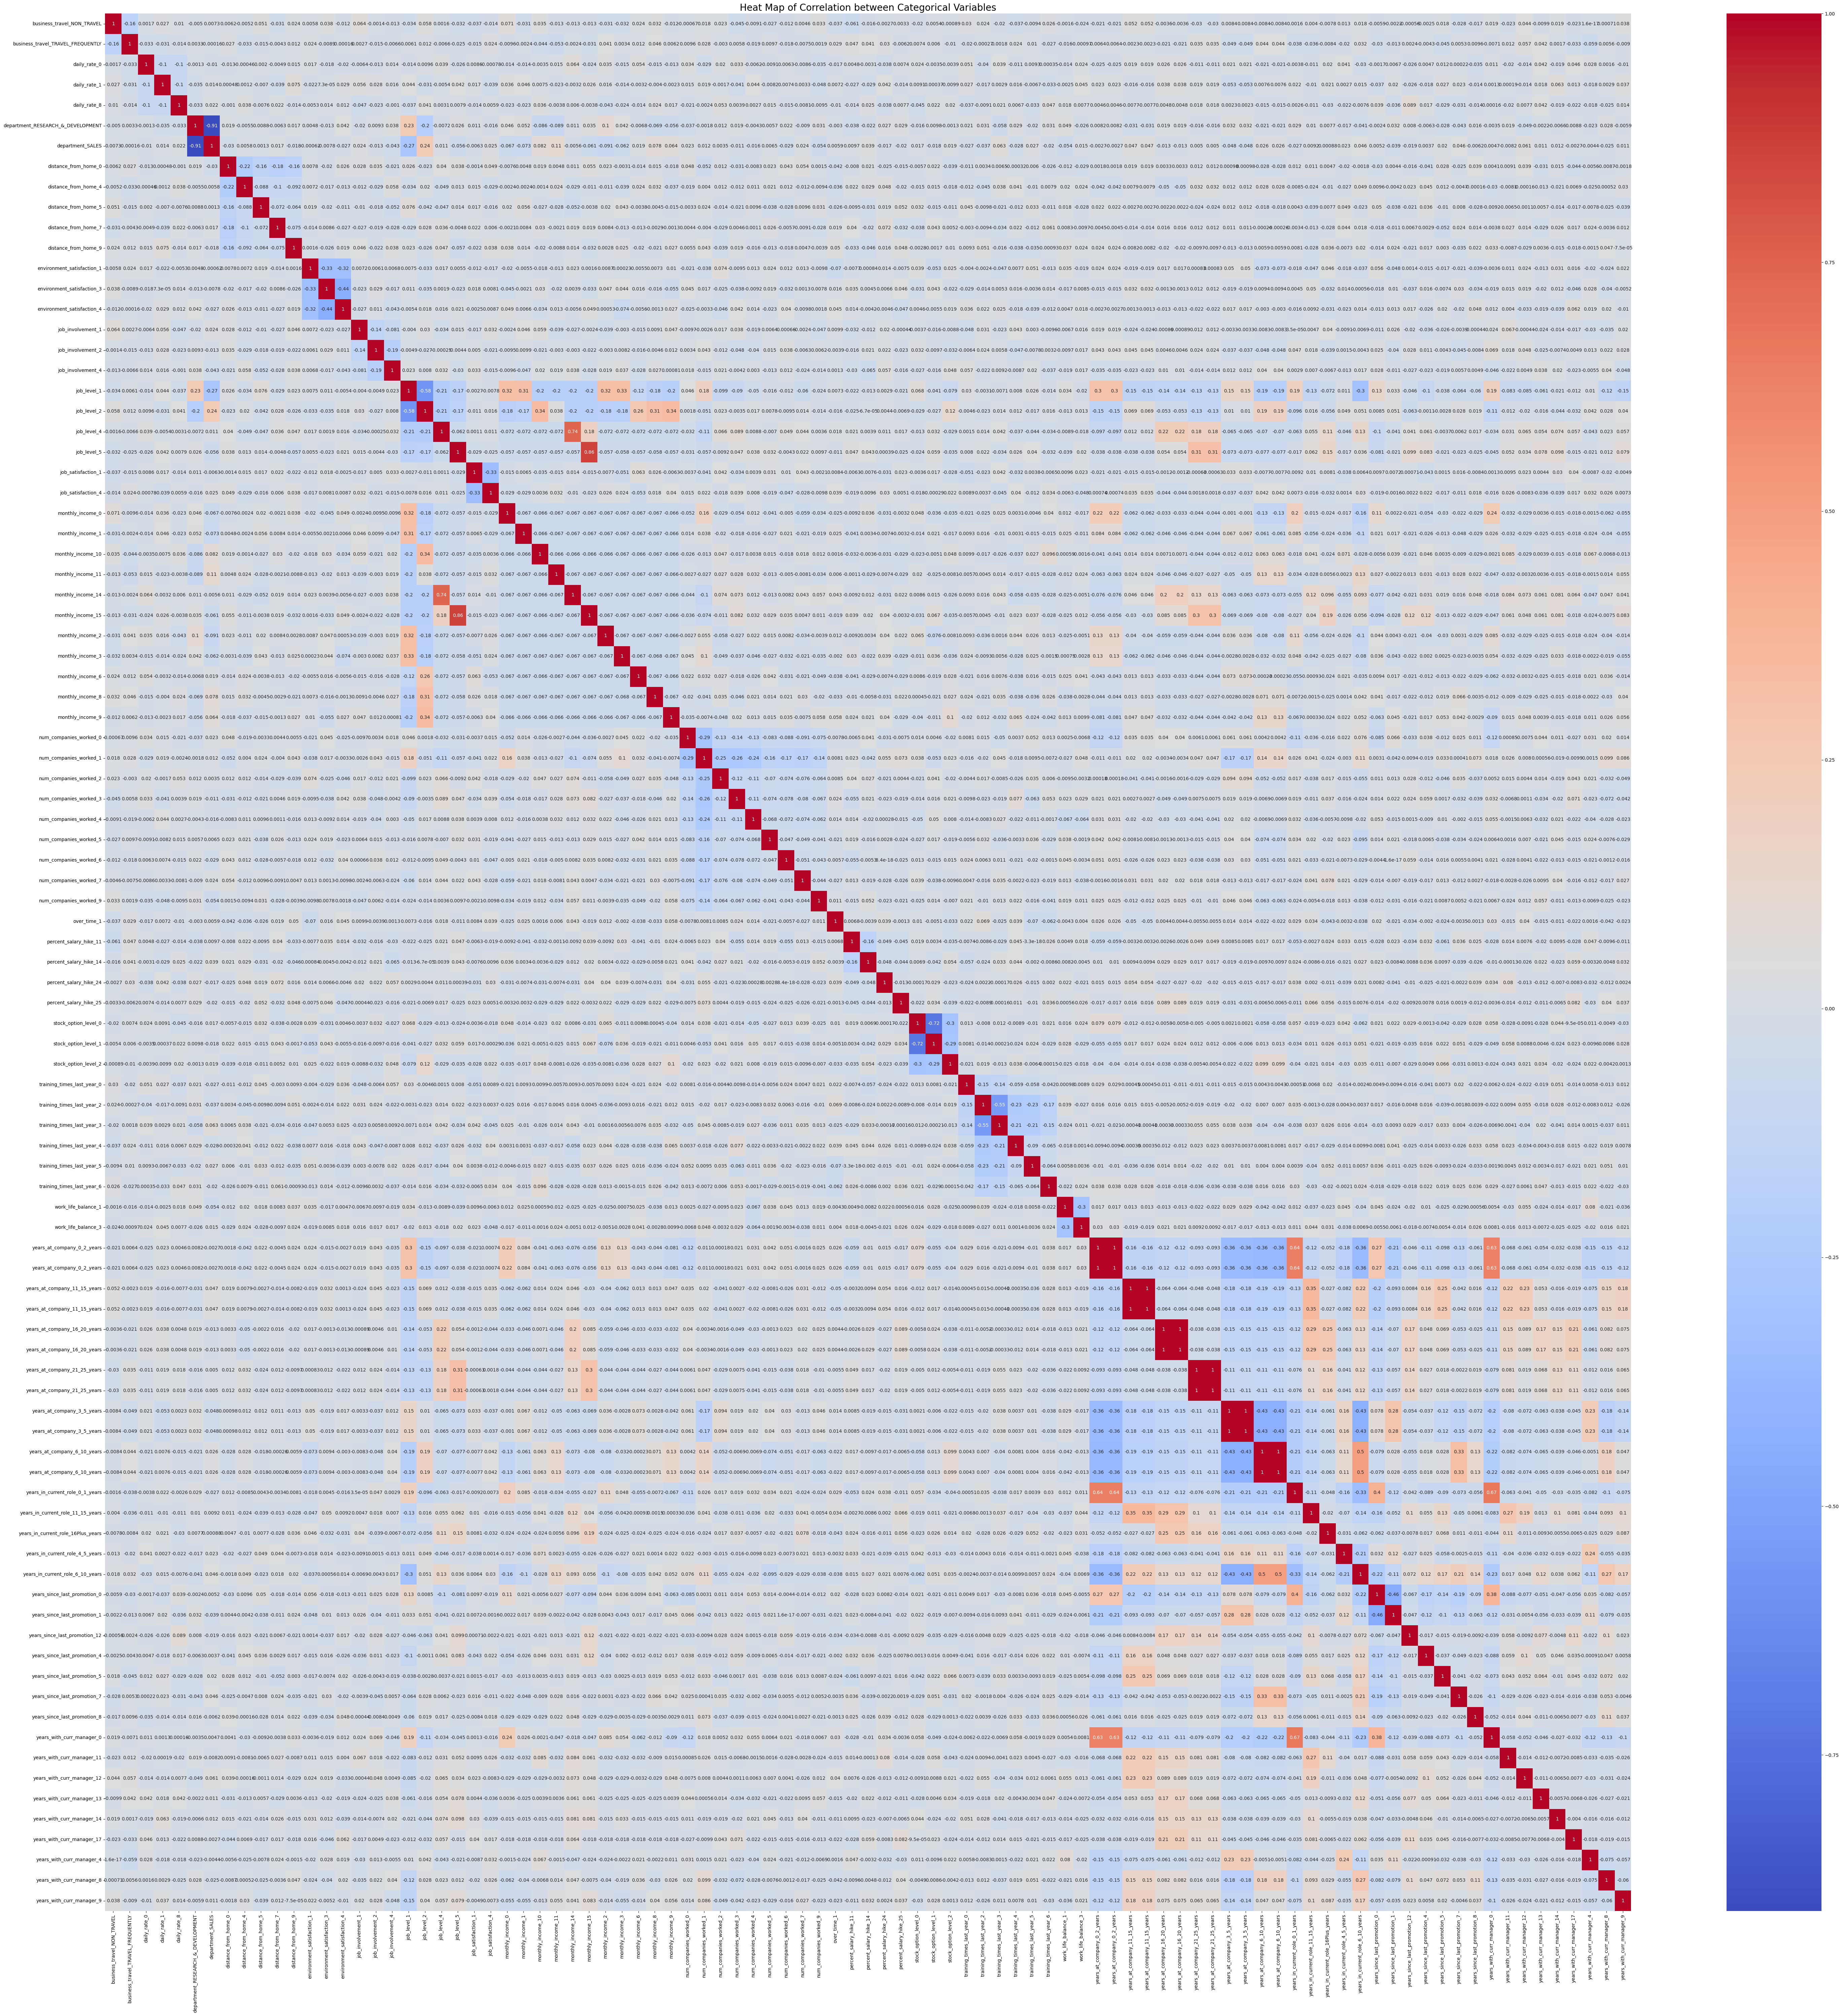

In [133]:
fig, ax = plt.subplots()
fig.set_size_inches(60, 60)  # Set the figure size

ax.set_title("Heat Map of Correlation between Categorical Variables", fontsize=20)

sns.heatmap(X.corr(), ax=ax, cmap="coolwarm", annot=True)  # Added cmap and annot for readability

plt.tight_layout()
plt.show()
plt.close()

In [134]:
correlation_matrix = X.corr().abs()

threshold = 0.5

high_correlation = high_correlation = correlation_matrix[
    (correlation_matrix > threshold) & (correlation_matrix < 1)
]

high_correlation_pairs = high_correlation.stack().reset_index()
high_correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

high_correlation_pairs = high_correlation_pairs.drop_duplicates(
    subset=['Correlation']
).sort_values(by='Correlation', ascending=False)

print(f"Highly correlated feature pairs (correlation > {threshold}):")
high_correlation_pairs.reset_index(drop=True, inplace=True)
high_correlation_pairs

Highly correlated feature pairs (correlation > 0.5):


Feature 1                        Feature 2  \
0  department_RESEARCH_&_DEVELOPMENT                 department_SALES   
1                        job_level_5                monthly_income_15   
2                        job_level_4                monthly_income_14   
3               stock_option_level_0             stock_option_level_1   
4    years_in_current_role_0_1_years        years_with_curr_manager_0   
5         years_at_company_0_2_years  years_in_current_role_0_1_years   
6         years_at_company_0_2_years        years_with_curr_manager_0   
7                        job_level_1                      job_level_2   
8         training_times_last_year_2       training_times_last_year_3   

   Correlation  
0     0.906818  
1     0.858887  
2     0.742299  
3     0.716145  
4     0.669207  
5     0.638266  
6     0.633512  
7     0.578086  
8     0.545183

## Build Interaction Effects

In [135]:
X = create_interaction_effects(X, "job_level", "monthly_income", attrition_series)
X.head(10)

Updated DataFrame shape: (1470, 92)


business_travel_NON_TRAVEL  business_travel_TRAVEL_FREQUENTLY  \
0                         0.0                                0.0   
1                         0.0                                1.0   
2                         0.0                                0.0   
3                         0.0                                1.0   
4                         0.0                                0.0   
5                         0.0                                1.0   
6                         0.0                                0.0   
7                         0.0                                0.0   
8                         0.0                                1.0   
9                         0.0                                0.0   

   daily_rate_0  daily_rate_1  daily_rate_8  \
0           0.0           0.0           0.0   
1           0.0           1.0           0.0   
2           0.0           0.0           0.0   
3           0.0           0.0           0.0   
4           0.0           0.0           0.0   
5           0.0           0.0           0.0   
6           0.0           0.0           0.0   
7           0.0           0.0           0.0   
8           1.0           0.0           0.0   
9           0.0           0.0           0.0   

   department_RESEARCH_&_DEVELOPMENT  department_SALES  distance_from_home_0  \
0                                0.0               1.0                   1.0   
1                                1.0               0.0                   0.0   
2                                1.0               0.0                   1.0   
3                                1.0               0.0                   0.0   
4                                1.0               0.0                   1.0   
5                                1.0               0.0                   1.0   
6                                1.0               0.0                   0.0   
7                                1.0               0.0                   0.0   
8                                1.0               0.0                   0.0   
9                                1.0               0.0                   0.0   

   distance_from_home_4  distance_from_home_5  ...  \
0                   0.0                   0.0  ...   
1                   1.0                   0.0  ...   
2                   0.0                   0.0  ...   
3                   0.0                   0.0  ...   
4                   0.0                   0.0  ...   
5                   0.0                   0.0  ...   
6                   0.0                   0.0  ...   
7                   0.0                   0.0  ...   
8                   0.0                   0.0  ...   
9                   0.0                   0.0  ...   

   years_with_curr_manager_14  years_with_curr_manager_17  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   
5                         0.0                         0.0   
6                         0.0                         0.0   
7                         0.0                         0.0   
8                         0.0                         0.0   
9                         0.0                         0.0   

   years_with_curr_manager_4  years_with_curr_manager_8  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   
5                        0.0                        0.0   
6                        0.0                        0.0   
7                        0.0                        0.0   
8                        0.0                        1.0  

In [136]:
X = create_interaction_effects(X, "years_at_company", "years_in_current_role", attrition_series)
X.head()

Updated DataFrame shape: (1470, 95)


business_travel_NON_TRAVEL  business_travel_TRAVEL_FREQUENTLY  \
0                         0.0                                0.0   
1                         0.0                                1.0   
2                         0.0                                0.0   
3                         0.0                                1.0   
4                         0.0                                0.0   

   daily_rate_0  daily_rate_1  daily_rate_8  \
0           0.0           0.0           0.0   
1           0.0           1.0           0.0   
2           0.0           0.0           0.0   
3           0.0           0.0           0.0   
4           0.0           0.0           0.0   

   department_RESEARCH_&_DEVELOPMENT  department_SALES  distance_from_home_0  \
0                                0.0               1.0                   1.0   
1                                1.0               0.0                   0.0   
2                                1.0               0.0                   1.0   
3                                1.0               0.0                   0.0   
4                                1.0               0.0                   1.0   

   distance_from_home_4  distance_from_home_5  ...  years_with_curr_manager_8  \
0                   0.0                   0.0  ...                        0.0   
1                   1.0                   0.0  ...                        0.0   
2                   0.0                   0.0  ...                        0.0   
3                   0.0                   0.0  ...                        0.0   
4                   0.0                   0.0  ...                        0.0   

   years_with_curr_manager_9  job_level_1_x_monthly_income_0  \
0                        0.0                             0.0   
1                        0.0                             0.0   
2                        0.0                             1.0   
3                        0.0                             0.0   
4                        0.0                             0.0   

   job_level_1_x_monthly_income_1  job_level_1_x_monthly_income_2  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   job_level_4_x_monthly_income_14  job_level_2_x_monthly_income_6  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   

   years_at_company_0_2_years_x_years_in_current_role_0_1_years  \
0                                                0.0              
1                                                0.0              
2                                                1.0              
3                                                0.0              
4                                                0.0              

   years_at_company_6_10_years_x_years_in_current_role_6_10_years  \
0                                                0.0                
1                                                1.0                
2                                                0.0                
3                                                1.0                
4                                                0.0                

   years_at_company_11_15_years_x_years_in_current_role_6_10_years  
0                                                0.0                
1                                                0.0                
2                                                0.0                
3                           

In [137]:
X = create_interaction_effects(
    X, "years_at_company", "years_with_curr_manager", attrition_series
)
X.head(10)

Updated DataFrame shape: (1470, 98)


business_travel_NON_TRAVEL  business_travel_TRAVEL_FREQUENTLY  \
0                         0.0                                0.0   
1                         0.0                                1.0   
2                         0.0                                0.0   
3                         0.0                                1.0   
4                         0.0                                0.0   
5                         0.0                                1.0   
6                         0.0                                0.0   
7                         0.0                                0.0   
8                         0.0                                1.0   
9                         0.0                                0.0   

   daily_rate_0  daily_rate_1  daily_rate_8  \
0           0.0           0.0           0.0   
1           0.0           1.0           0.0   
2           0.0           0.0           0.0   
3           0.0           0.0           0.0   
4           0.0           0.0           0.0   
5           0.0           0.0           0.0   
6           0.0           0.0           0.0   
7           0.0           0.0           0.0   
8           1.0           0.0           0.0   
9           0.0           0.0           0.0   

   department_RESEARCH_&_DEVELOPMENT  department_SALES  distance_from_home_0  \
0                                0.0               1.0                   1.0   
1                                1.0               0.0                   0.0   
2                                1.0               0.0                   1.0   
3                                1.0               0.0                   0.0   
4                                1.0               0.0                   1.0   
5                                1.0               0.0                   1.0   
6                                1.0               0.0                   0.0   
7                                1.0               0.0                   0.0   
8                                1.0               0.0                   0.0   
9                                1.0               0.0                   0.0   

   distance_from_home_4  distance_from_home_5  ...  \
0                   0.0                   0.0  ...   
1                   1.0                   0.0  ...   
2                   0.0                   0.0  ...   
3                   0.0                   0.0  ...   
4                   0.0                   0.0  ...   
5                   0.0                   0.0  ...   
6                   0.0                   0.0  ...   
7                   0.0                   0.0  ...   
8                   0.0                   0.0  ...   
9                   0.0                   0.0  ...   

   job_level_1_x_monthly_income_1  job_level_1_x_monthly_income_2  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   
5                             0.0                             0.0   
6                             0.0                             0.0   
7                             0.0                             0.0   
8                             0.0                             0.0   
9                             0.0                             0.0   

   job_level_4_x_monthly_income_14  job_level_2_x_monthly_income_6  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
5                              0.0                             0.0   
6         

## Split the Data

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Define Hyperparamters and Objective

In [174]:
class_count = Counter(y_train)
scale_pos_weight = class_count[0] / class_count[1]

# Define the hyperparameter tuning objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', scale_pos_weight / 5, scale_pos_weight * 5),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'eval_metric': 'aucpr',  # Place `eval_metric` inside `params`
    }

    # Initialize Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_pr_scores = []

    # Perform cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Initialize the model with parameters
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_test_cv, y_test_cv)],
            verbose=False
        )

        # Predict probabilities on the validation fold for AUC-PR
        y_pred_proba_cv = model.predict_proba(X_test_cv)[:, 1]
        
        # Calculate precision, recall, and AUC-PR
        precision, recall, _ = precision_recall_curve(y_test_cv, y_pred_proba_cv)
        auc_pr = sk_auc(recall, precision)  # Calculate AUC-PR for the fold
        auc_pr_scores.append(auc_pr)

    # Return the average AUC-PR from cross-validation folds
    return np.mean(auc_pr_scores)

## Run the Model

In [175]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-11-02 03:09:17,784] A new study created in memory with name: no-name-9116ad61-347f-4847-9535-2c873e429d2a
[I 2024-11-02 03:09:23,071] Trial 0 finished with value: 0.5315685073416342 and parameters: {'n_estimators': 744, 'max_depth': 4, 'learning_rate': 0.0011523584837688755, 'subsample': 0.6123138292682808, 'colsample_bytree': 0.653683196709829, 'gamma': 2.3693394939669203, 'alpha': 7.852277648181573, 'lambda': 3.309104891807265, 'min_child_weight': 10, 'scale_pos_weight': 5.300187167883551, 'max_delta_step': 2}. Best is trial 0 with value: 0.5315685073416342.
[I 2024-11-02 03:09:27,604] Trial 1 finished with value: 0.5726843141470119 and parameters: {'n_estimators': 782, 'max_depth': 3, 'learning_rate': 0.00706295030837636, 'subsample': 0.7270769795242076, 'colsample_bytree': 0.7924500404181565, 'gamma': 0.043119692177741364, 'alpha': 4.000458851216165, 'lambda': 4.848075440441126, 'min_child_weight': 10, 'scale_pos_weight': 13.938429639714716, 'max_delta_step': 3}. Best is tr

## Evaluate

In [176]:
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value:  0.6176743693919458
  Params: 
    n_estimators: 723
    max_depth: 3
    learning_rate: 0.08782126704908025
    subsample: 0.7682994593508832
    colsample_bytree: 0.6129756503720436
    gamma: 2.853988862881502
    alpha: 4.616503126921987
    lambda: 8.83293327016248
    min_child_weight: 8
    scale_pos_weight: 2.6475503353507
    max_delta_step: 8


In [177]:
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params, eval_metric='logloss')

In [178]:
best_model.fit(X_train, y_train)

XGBClassifier(alpha=4.616503126921987, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6129756503720436, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.853988862881502, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=8.83293327016248,
              learning_rate=0.08782126704908025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=8,
              max_depth=3, max_leaves=None, min_child_weight=8, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=723,
              n_jobs=None, ...)

In [179]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  

In [180]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Best model performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  AUC: {auc:.4f}")

Best model performance:
  Accuracy: 0.8469
  Precision: 0.5185
  Recall: 0.5957
  F1 Score: 0.5545
  AUC: 0.8249


In [185]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

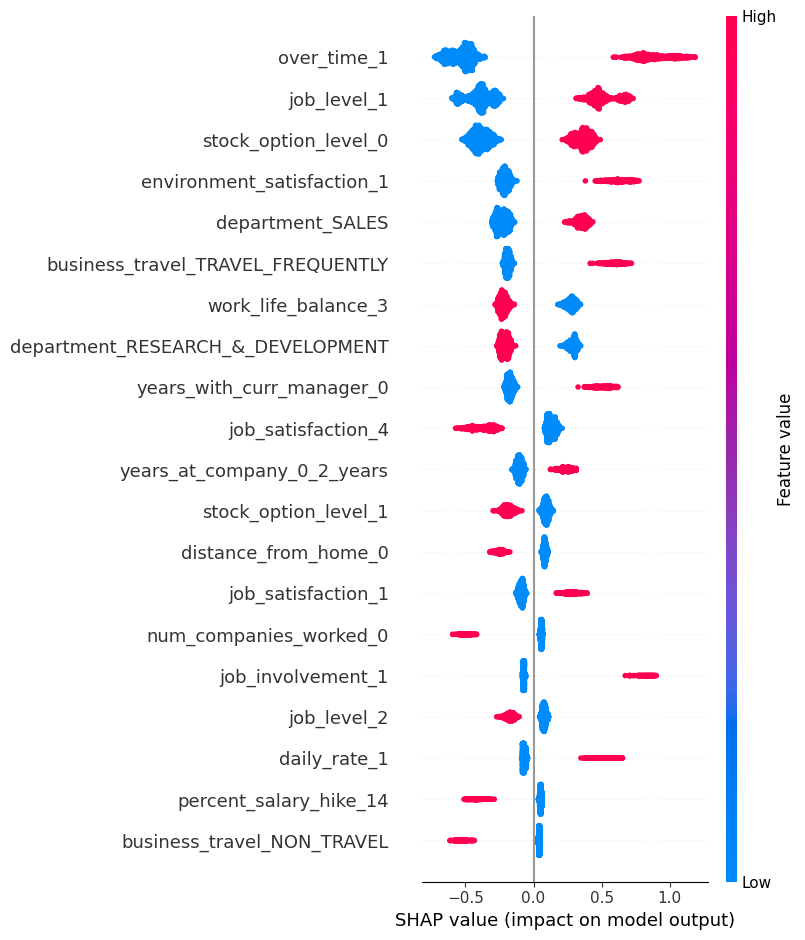

In [186]:
shap.summary_plot(shap_values, X)

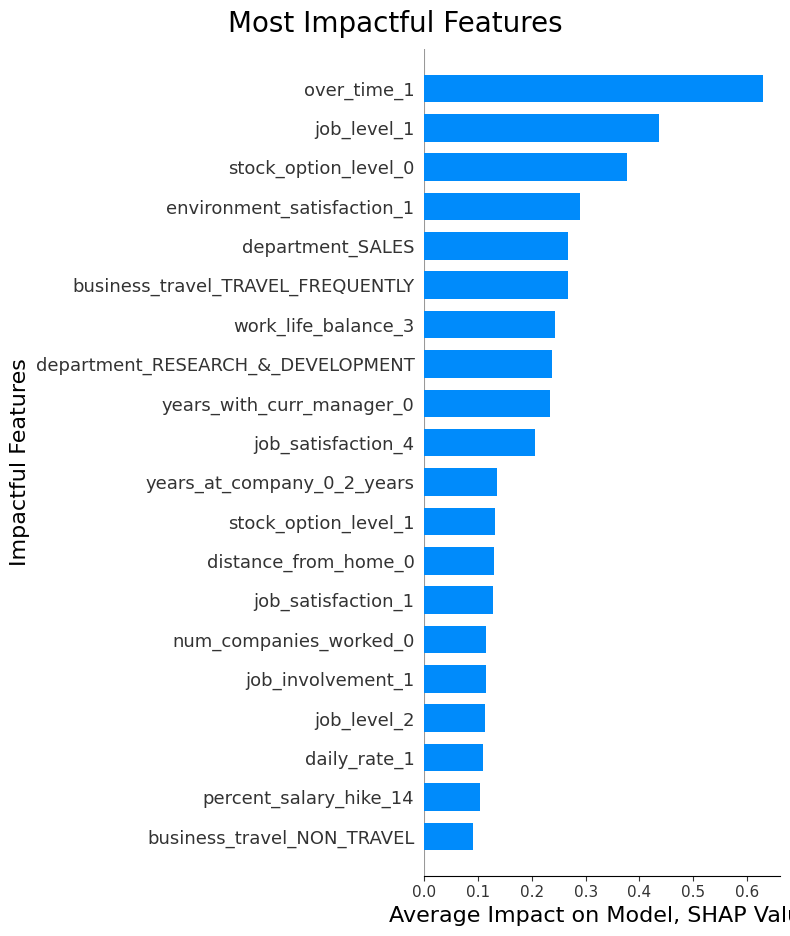

In [245]:
shap.summary_plot(
    shap_values, X, plot_type="bar",title="Most Impactful Features", show=False
)
plt.gcf().suptitle("Most Impactful Features", fontsize=20)
plt.xlabel("Average Impact on Model, SHAP Value", fontsize=16)
plt.ylabel("Impactful Features", fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

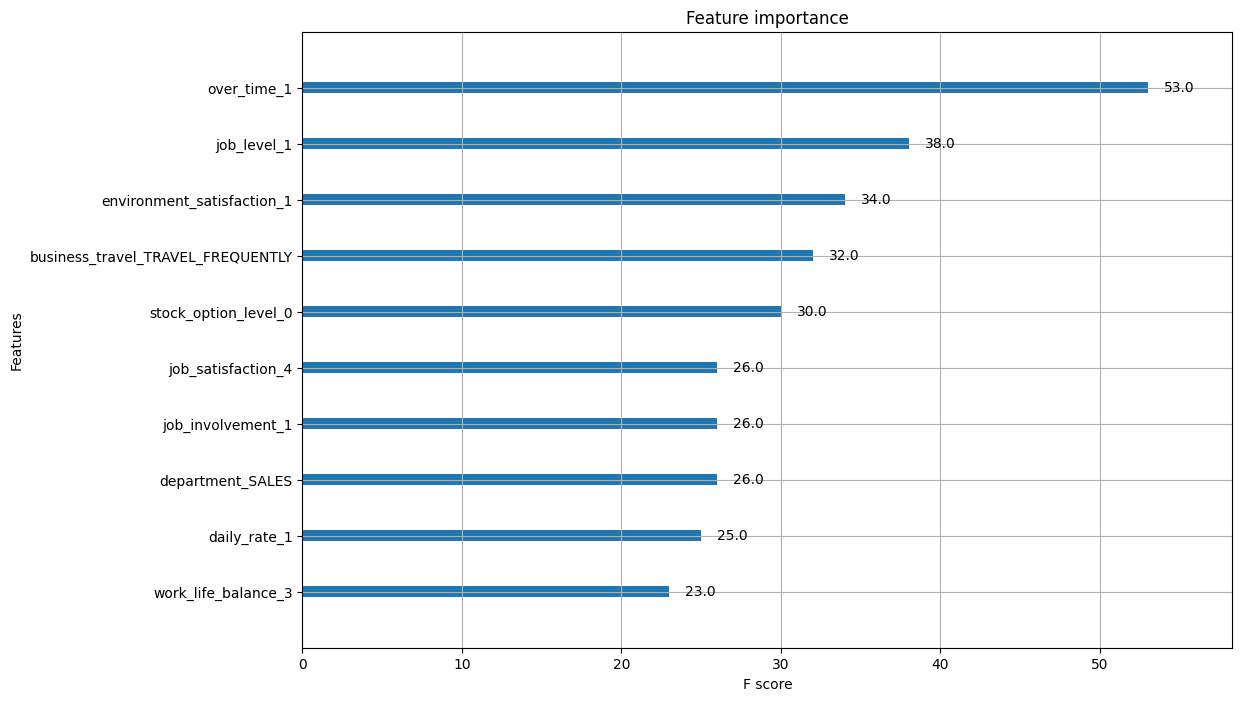

In [188]:
xgb.plot_importance(best_model, importance_type="weight", max_num_features=10)
plt.show()

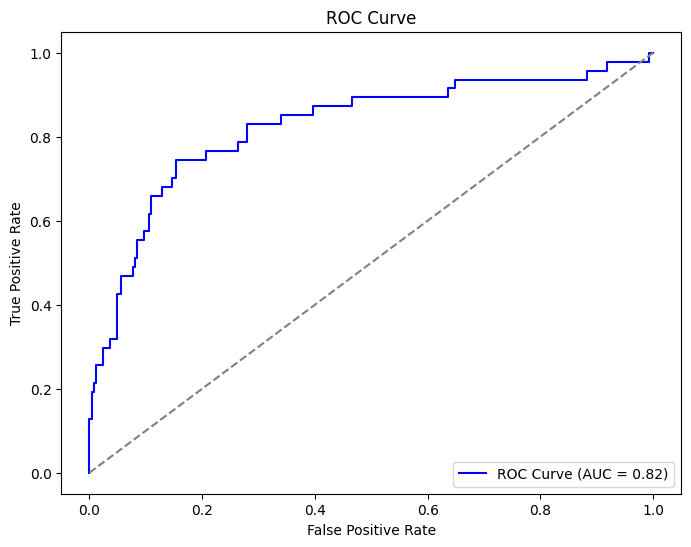

In [189]:
# Get predicted probabilities for the positive class (attrition)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC for ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


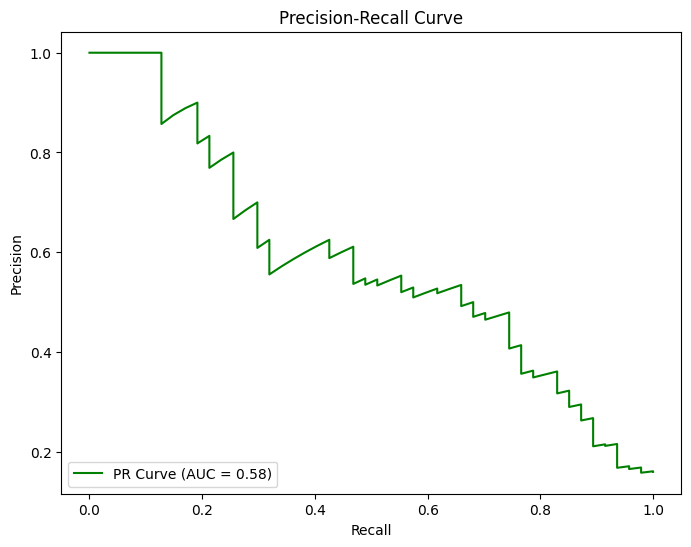

In [190]:
# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate AUC for the Precision-Recall curve
pr_auc = sk_auc(recall, precision)

# Plot Precision-Recall curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


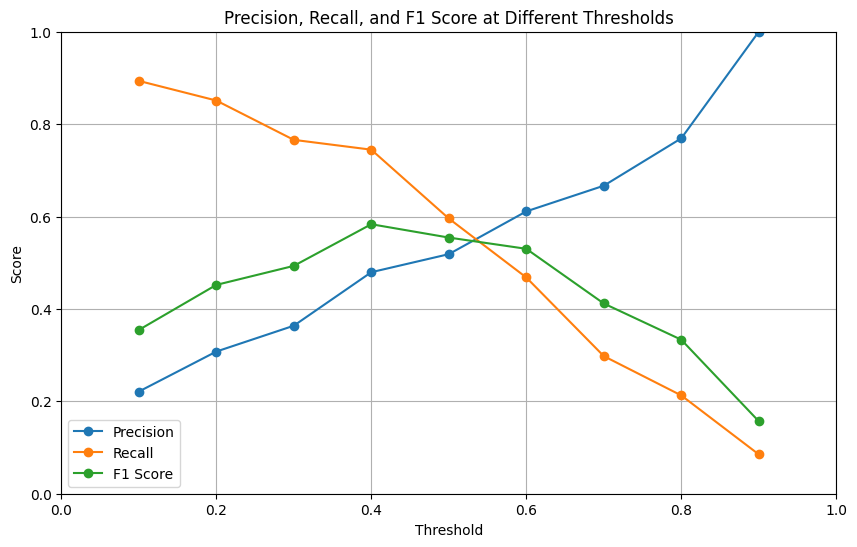

In [191]:
# Define a range of thresholds to evaluate
thresholds = [0.1 * i for i in range(1, 10)]  # Adjust range and step as needed

# Initialize lists to store metrics for each threshold
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_threshold,zero_division=0)
    recall = recall_score(y_test, y_pred_threshold,zero_division=0)
    f1 = f1_score(y_test, y_pred_threshold)
    
    # Store the results
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the metrics against the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label="Precision", marker='o')
plt.plot(thresholds, recall_scores, label="Recall", marker='o')
plt.plot(thresholds, f1_scores, label="F1 Score", marker='o')
plt.xlabel("Threshold")
plt.xlim(0, 1)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Precision, Recall, and F1 Score at Different Thresholds")
plt.grid()
plt.legend()
plt.show()


<Figure size 2000x1000 with 0 Axes>

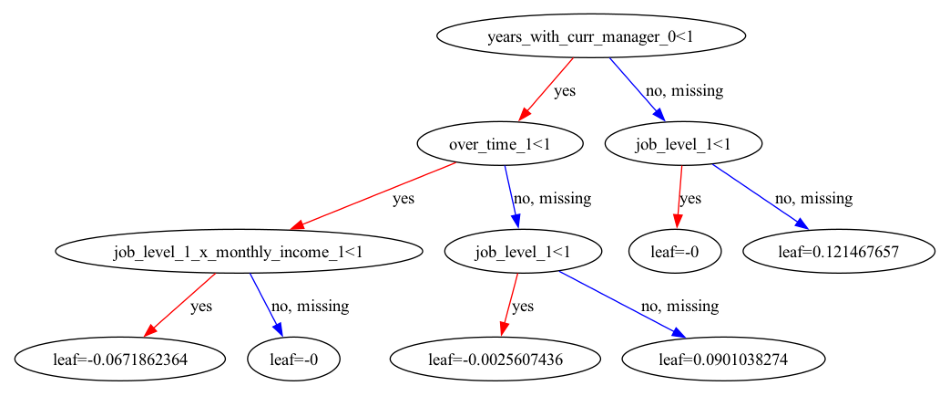

In [192]:
plt.figure(figsize=(20, 10))
xgb.plot_tree(best_model, num_trees=0)  # Adjust num_trees to view different trees
plt.show()

# Final Evaluation

In [193]:
best_model.fit(X, y)

y_pred_all = best_model.predict(X)  # Binary predictions (0 or 1)
y_pred_proba_all = best_model.predict_proba(X)[:, 1]  # Probabilities for class 1

# Calculate metrics using y_pred_all (binary) and y_pred_proba_all (probabilities)
accuracy = accuracy_score(y, y_pred_all)
precision = precision_score(y, y_pred_all, zero_division=0)
recall = recall_score(y, y_pred_all, zero_division=0)
f1 = f1_score(y, y_pred_all)
auc = roc_auc_score(y, y_pred_proba_all)  # Use probabilities for AUC

# Display the results
print("Best model performance on All Data:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  AUC: {auc:.4f}")

Best model performance on All Data:
  Accuracy: 0.8898
  Precision: 0.6415
  Recall: 0.7173
  F1 Score: 0.6773
  AUC: 0.9100


In [194]:
y_pred_all = best_model.predict(X)
y_pred_proba_all = best_model.predict_proba(X)[:, 1]

In [195]:
auc_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
print(f"Mean AUC from 5-Fold CV: {np.mean(auc_scores):.4f}")

Mean AUC from 5-Fold CV: 0.8342


In [204]:
predict_df = pd.DataFrame(
    {
        "probability_to_exit" :y_pred_proba_all,
        "predicted_result": y_pred_all,
        "actual_result": attrition_series
    }
)

In [213]:
false_negatives = predict_df[
    (predict_df["actual_result"] == 1) 
    & (predict_df["predicted_result"] == 0)
]

true_positives = predict_df[
    (predict_df["actual_result"] == 1) 
    & (predict_df["predicted_result"] == 1)
]

In [220]:
min_overlap = max(
    false_negatives["probability_to_exit"].min(), 
    true_positives["probability_to_exit"].min()
)

max_overlap = min(
    false_negatives["probability_to_exit"].max(),
      true_positives["probability_to_exit"].max()
)
min_overlap, max_overlap

(np.float32(0.50693524), np.float32(0.48884353))

In [221]:

overlapping_probs = np.concatenate([
    false_negatives[
        (false_negatives["probability_to_exit"] >= min_overlap) 
        & (false_negatives["probability_to_exit"] <= max_overlap)
    ]["probability_to_exit"],
    true_positives[
        (true_positives["probability_to_exit"] >= min_overlap)
        & (true_positives["probability_to_exit"] <= max_overlap)]
        ["probability_to_exit"]
])

overlapping_probs

array([], dtype=float32)

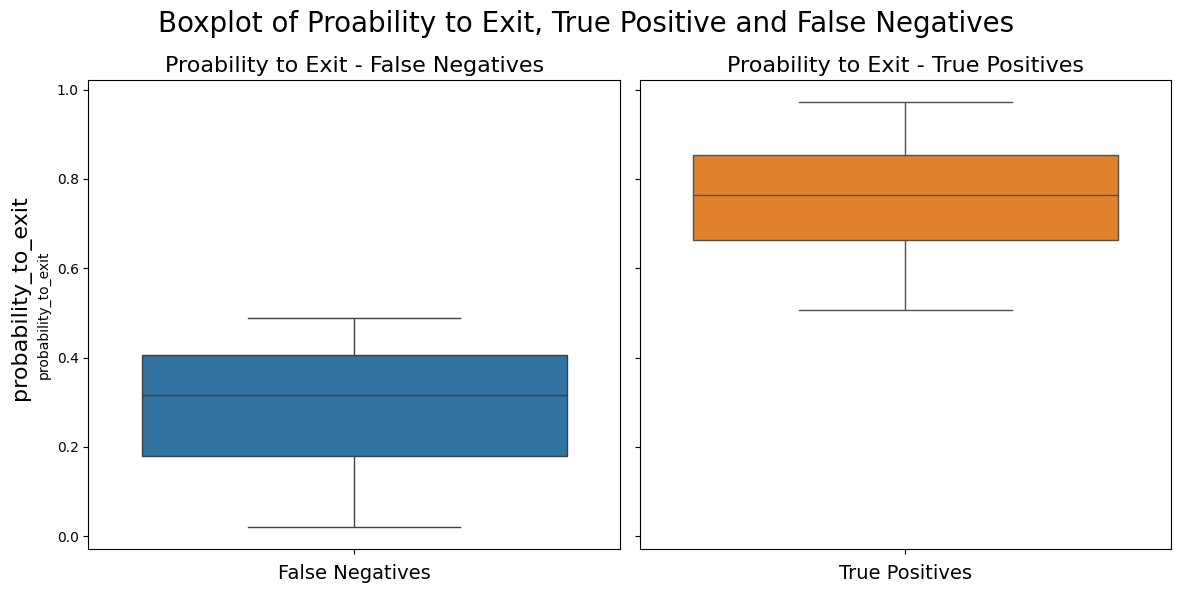

In [247]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot False Negatives
plt.suptitle("Boxplot of Proability to Exit, True Positive and False Negatives", fontsize=20)
ax1.set_title("Proability to Exit - False Negatives", fontsize=16)
sns.boxplot(data=false_negatives, y='probability_to_exit', ax=ax1)
ax1.set_xlabel("False Negatives", fontsize=14)

# Plot True Positives
ax2.set_title("Proability to Exit - True Positives", fontsize=16)
sns.boxplot(data=true_positives, y='probability_to_exit', ax=ax2, color='tab:orange')
ax2.set_xlabel("True Positives", fontsize=14)

# Set common y-axis label
fig.supylabel("probability_to_exit", fontsize=16)

plt.tight_layout()
plt.show()

In [231]:
false_negative_upper = false_negatives["probability_to_exit"].quantile(0.75)
true_positive_lower = true_positives["probability_to_exit"].quantile(0.25)
false_negative_upper, true_positive_lower

(np.float64(0.40488773584365845), np.float64(0.6634343713521957))

In [232]:
tipping_point = (false_negative_upper + true_positive_lower) / 2
tipping_point

np.float64(0.5341610535979271)

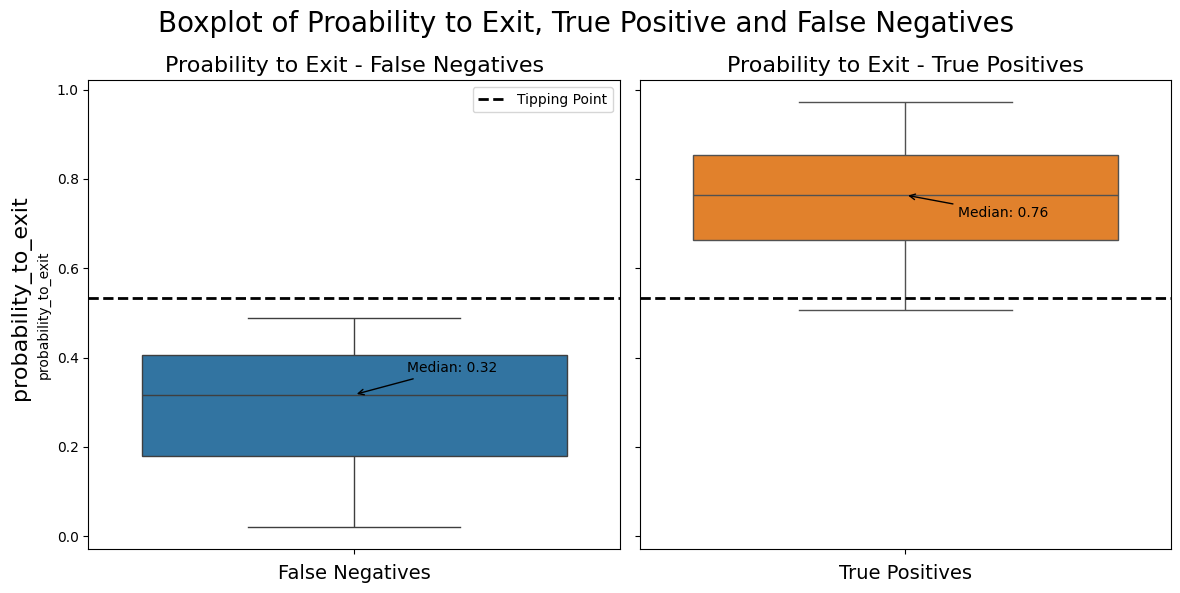

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot False Negatives
plt.suptitle("Boxplot of Proability to Exit, True Positive and False Negatives", fontsize=20)
ax1.set_title("Proability to Exit - False Negatives", fontsize=16)
sns.boxplot(data=false_negatives, y='probability_to_exit', ax=ax1)
ax1.set_xlabel("False Negatives", fontsize=14)

ax1.annotate(
    f"Median: {false_negatives['probability_to_exit'].median():.2f}", 
      xy=(0, false_negatives['probability_to_exit'].median()), 
      xytext=(0.1, false_negatives['probability_to_exit'].median() + 0.05),
      arrowprops=dict(arrowstyle="->", color='black')
)

# Plot True Positives
ax2.set_title("Proability to Exit - True Positives", fontsize=16)
sns.boxplot(data=true_positives, y='probability_to_exit', ax=ax2, color='tab:orange')
ax2.set_xlabel("True Positives", fontsize=14)

ax2.annotate(
    f"Median: {true_positives['probability_to_exit'].median():.2f}", 
    xy=(0, true_positives['probability_to_exit'].median()),              
    xytext=(0.1, true_positives['probability_to_exit'].median() - 0.05),
    arrowprops=dict(arrowstyle="->", color='black')
)

ax1.axhline(tipping_point, color='k', ls='--', lw=2, label="Tipping Point")
ax2.axhline(tipping_point, color='k', ls='--', lw=2)

ax1.legend()

# Set common y-axis label
fig.supylabel("probability_to_exit", fontsize=16)



plt.tight_layout()
plt.show()

In [234]:
predict_df["intevention_flag"] = np.where(
    (predict_df["predicted_result"] == 1) 
    | (predict_df["probability_to_exit"] >= tipping_point), 
    1, 
    0
)

In [235]:
accuracy = accuracy_score(predict_df["actual_result"], predict_df["intevention_flag"])
precision = precision_score(predict_df["actual_result"], predict_df["intevention_flag"])
recall = recall_score(predict_df["actual_result"], predict_df["intevention_flag"])
f1 = f1_score(predict_df["actual_result"], predict_df["intevention_flag"])

print("Model Performance with Tipping Point-Based Intervention Threshold:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  Tipping Point Probability Threshold: {tipping_point:.4f}")

Model Performance with Tipping Point-Based Intervention Threshold:
  Accuracy: 0.8898
  Precision: 0.6415
  Recall: 0.7173
  F1 Score: 0.6773
  Tipping Point Probability Threshold: 0.5342
